## Covid-19 project for AISaturdays Alicante

---

Last updated: 03/07/2020

This notebook is my contribution to my groups's project within the AI Saturdays programme in Alicante.

The project verses about the covid-19 pandemic expansion and how machine learning models can be utilized to predict its evolution. 

I first conduct a descriptive analysis of the pandemic evolution across a number of countries, covering some of the hardest hit countries in Europe and the Americas, and finally predictive models with neural networks are created and validated for the most relevant variables.

The eight countries included in this research work are:

- Spain, Italy, France and Germany in the European Union
- UK, Brazil, Canada, and USA in the rest of the world

The data is a simplified set of the data files published by the Johns Hopkins University and can be obtained from their COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at :

https://github.com/CSSEGISandData/COVID-19

In [1]:
# Usual library imports.... more later 
import numpy as np
import pandas as pd
import datetime
from datetime import date
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
mpl.rcdefaults()

plt.style.use('seaborn-whitegrid')

import warnings
warnings.filterwarnings("ignore")

# Set precision to two decimals
pd.set_option("display.precision", 4)

# Define date format for charts like Apr 16 or Mar 8
my_date_fmt = mdates.DateFormatter('%b %e')

## Data loading and pre-process

In [2]:
# Data loading
df_cases = pd.read_csv("../input/covid19-casos-confirmados-paises-15052020/covid19_casos_confirmados_paises_03072020.csv", sep=',')
df_deaths = pd.read_csv("../input/covid19-casos-confirmados-paises-15052020/covid19_casos_fallecidos_paises_03072020.csv", sep=',')
df_recovered = pd.read_csv("../input/covid19-casos-confirmados-paises-15052020/covid19_casos_recuperados_paises_03072020.csv", sep=',')

In [3]:
# Drop Australia and Iran
df_cases.drop(columns=['AUSTRALIA', 'IRAN'], inplace=True)
df_deaths.drop(columns=['AUSTRALIA', 'IRAN'], inplace=True)
df_recovered.drop(columns=['AUSTRALIA', 'IRAN'], inplace=True)

In [4]:
# Get last date for charts
last_date = str(df_cases.iloc[-1,0])
print('Last date in the set: ' + last_date)

Last date in the set: 3/7/2020


In [5]:
# Convert FECHA column to datetime format and set as index
df_cases['FECHA'] = pd.to_datetime(df_cases['FECHA'], format='%d/%m/%Y')
df_cases.set_index('FECHA', inplace=True)
df_deaths['FECHA'] = pd.to_datetime(df_deaths['FECHA'], format='%d/%m/%Y')
df_deaths.set_index('FECHA', inplace=True)
df_recovered['FECHA'] = pd.to_datetime(df_recovered['FECHA'], format='%d/%m/%Y')
df_recovered.set_index('FECHA', inplace=True)

In [6]:
# Fill nulls with zero
df_cases.fillna(value=0, inplace=True)
df_deaths.fillna(value=0, inplace=True)
df_recovered.fillna(value=0, inplace=True)

## Calculate other variables: mortality and active cases

The three available (measured) variables in our data are the number of confirmed cases, recovered and deaths. They are all cumulative variables.

From these three variables we can calculate the number of **active cases** at any point in time, as follows:

> **Active Cases (t) = Confirmed Cases (t) - Recovered (t) - Deaths (t)**

where t is the date.

Whilst confirmed, recovered and deaths are cumulative variables and therefore always increase, the active cases variable will show a bell-like shape, initially growing until reaching a peak, to decrease then slowly until it reaches zero, once the pandemic is fully erradicated. Beccause life is more complicated than algorithms and Python code, we will see camels, dromedaries and not just perfectly shaped bells.

Another variable of interest that we can calculate from the measured variables is Mortality(expressed in %), defined as:

> **Mortality % (t) = 100 * Deaths (t) / Confirmed Cases (t)**

Unlike the others, the mortality will fluctuate greatly (and it will not matter much) throughout the pandemic expansion. This is because the whilst the number of deaths is reasonably well known, that is not the case for the number of cases which is just an estimation of all infections (only those that have been detected through testing). There is still some value in having a look at the mortality figures and compare across the set of countries.

In [7]:
# Calculate Active cases = Confirmed - Deaths - Recovered
df_active = pd.DataFrame(columns=df_cases.columns, index=df_cases.index)
for col in df_cases.columns:
    df_active[col] = df_cases[col] - df_deaths[col] - df_recovered[col]

In [8]:
# Calculate Mortality = Deaths / Confirmed * 100
df_mortality = pd.DataFrame(columns=df_cases.columns, index=df_cases.index)
for col in df_cases.columns:
    df_mortality[col] = 100 * df_deaths[col] / df_cases[col]

Note that the data used in this work only accounts for PCR diagnosed cases. If you compare these numbers with other sources such as www.worldometers.info/coronavirus/ you might find a significant difference in the number of confirmed cases (around 50K in the case of Spain). The reason for that is worldometers.info also accounts for cases diagnosed through other types of tests along with PCR. Recovered and death figures seem to be more aligned.

In [9]:
df_totals = pd.DataFrame(columns=df_cases.columns, index=['CONFIRMED', 'DEATHS', 'RECOVERED', 'ACTIVE', 'MORTALITY'], dtype=np.int64)
df_totals.loc['CONFIRMED'] = df_cases.tail(1).values
df_totals.loc['DEATHS'] = df_deaths.tail(1).values
df_totals.loc['RECOVERED'] = df_recovered.tail(1).values
df_totals.loc['ACTIVE'] = df_active.tail(1).values
df_totals.loc['MORTALITY'] = df_mortality.tail(1).values
df_totals

,SPAIN,FRANCE,GERMANY,ITALY,UK,BRAZIL,CANADA,USA
CONFIRMED,250545.0000,195904.0000,196780.0000,241184.0000,284276.000,1.5391e+06,106946.0000,2.7942e+06
DEATHS,28385.0000,29812.0000,9010.0000,34833.0000,44131.000,6.1884e+04,8721.0000,1.2943e+05
RECOVERED,150376.0000,72181.0000,180300.0000,191467.0000,0.000,9.8462e+05,70232.0000,7.9040e+05
ACTIVE,71784.0000,93911.0000,7470.0000,14884.0000,240145.000,4.9258e+05,27993.0000,1.8743e+06
MORTALITY,11.3293,15.2177,4.5787,14.4425,15.524,4.0208e+00,8.1546,4.6323e+00


## Current numbers: country comparison

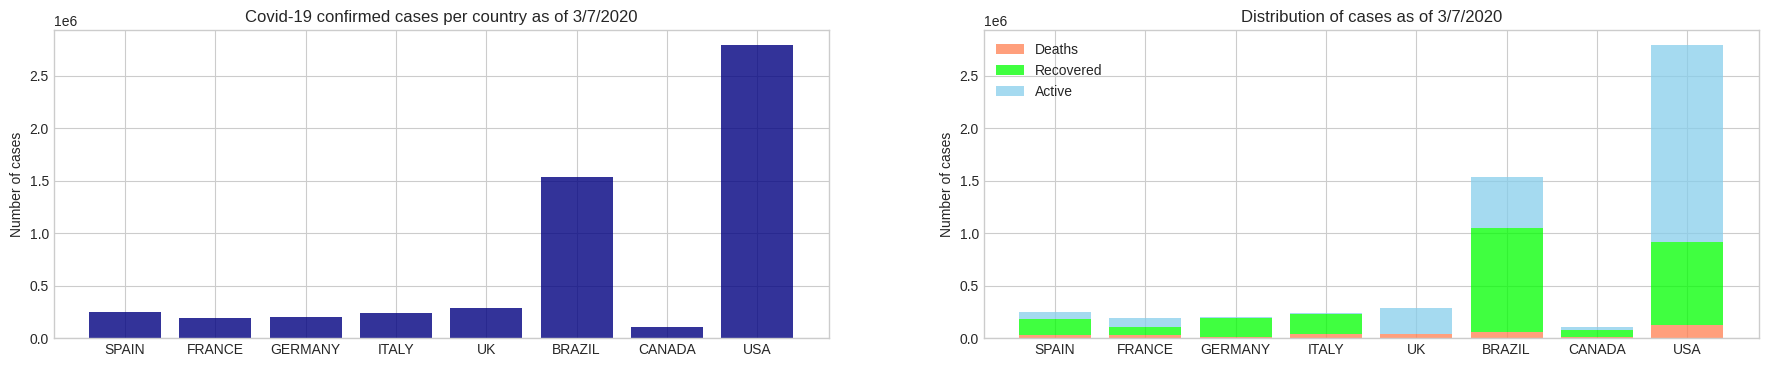

In [10]:
fig, ax = plt.subplots(1,2, figsize=(22,4))

# Chart 1: total number of cases per country
for x in df_cases.columns:
  ax[0].bar(x, df_cases[x].tail(1), alpha=0.8, color='navy')
ax[0].set_ylabel('Number of cases')
ax[0].set_title('Covid-19 confirmed cases per country as of ' + last_date)

# Chart 2: distribution of cases by status per country
labels = df_cases.columns
deaths = df_deaths.tail(1).values
recovered = df_recovered.tail(1).values
active = df_active.tail(1).values
ax[1].bar(labels, deaths[0], label='Deaths', color='coral', alpha=0.75)
ax[1].bar(labels, recovered[0], bottom=deaths[0], label='Recovered', color='lime', alpha=0.75)
ax[1].bar(labels, active[0], bottom=deaths[0] + recovered[0], label='Active', color='skyblue', alpha=0.75)
ax[1].set_ylabel('Number of cases')
ax[1].set_title('Distribution of cases as of ' + str(last_date))
ax[1].legend(loc='upper left', fontsize='medium')

plt.show()

## Evolution of cases: individual country plots

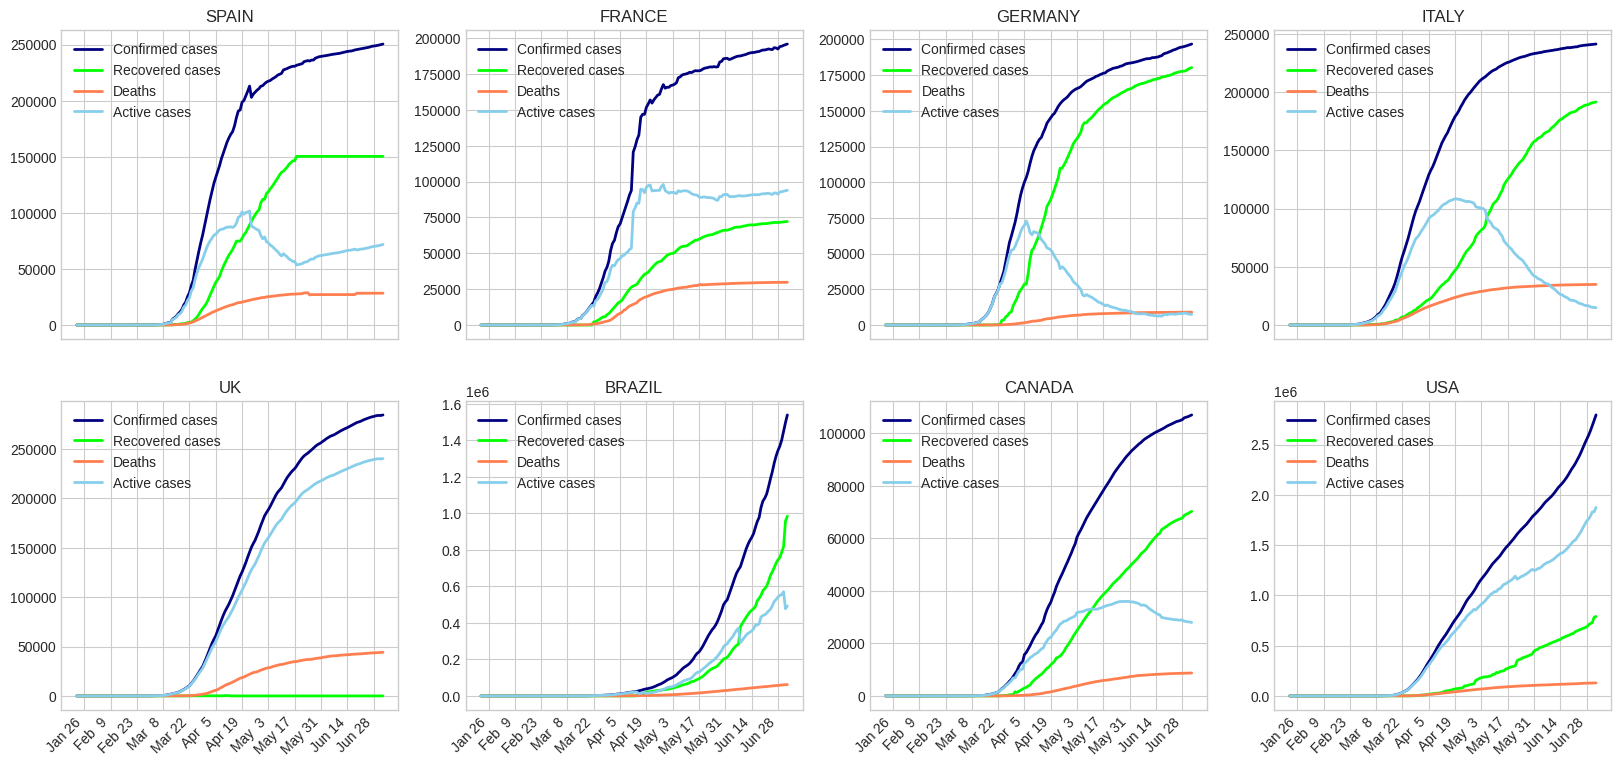

In [11]:
# Evolution ov covid-19 cases
fig1, ax1 = plt.subplots(2,4, figsize=(20,10))
#fig1.subplots_adjust(top=0.90)
i = 0
j = 0
for x in df_cases.columns:
  #dfx = df_cases[x]
  ax1[i,j].set_title(x)
  ax1[i,j].xaxis.set_major_formatter(my_date_fmt)
  ax1[i,j].xaxis.set_major_locator(plt.MultipleLocator(14)) 
  ax1[i,j].plot(df_cases.index, df_cases[x], color='navy', linewidth=2, label='Confirmed cases')
  ax1[i,j].plot(df_cases.index, df_recovered[x], color='lime', linewidth=2, label='Recovered cases')
  ax1[i,j].plot(df_cases.index, df_deaths[x], color='coral', linewidth=2, label='Deaths')  
  ax1[i,j].plot(df_cases.index, df_active[x], color='skyblue', linewidth=2, label='Active cases')
  ax1[i,j].legend(loc='upper left', fontsize='medium')
  if j<3:
    j = j + 1
  else:
    j = 0
    i = i + 1

#fig1.suptitle('Evolution of covid-19 cases by country', fontsize='xx-large')  
fig1.autofmt_xdate(rotation=45, ha='right')
plt.show()

## Mortality (%): individual country plots

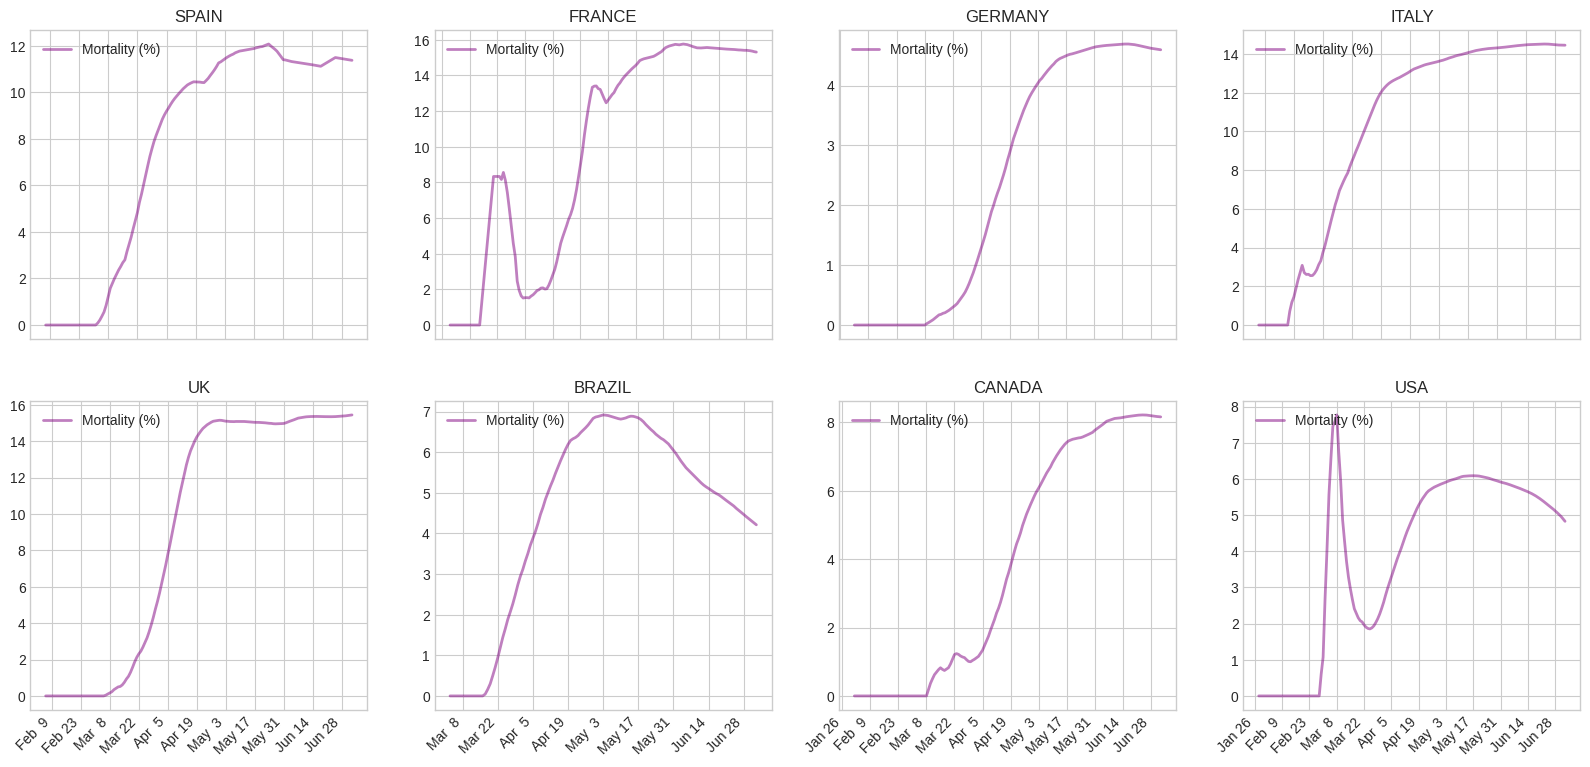

In [12]:
# Evolution ov covid-19 cases
fig2, ax2 = plt.subplots(2,4, figsize=(20,10))
#fig2.subplots_adjust(top=0.90)
i = 0
j = 0
for x in df_mortality.columns:
  ax2[i,j].set_title(x)
  ax2[i,j].xaxis.set_major_formatter(my_date_fmt)
  ax2[i,j].xaxis.set_major_locator(plt.MultipleLocator(14)) 
  ax2[i,j].plot(df_mortality[x].index, df_mortality[x].rolling(window=7).mean(), lw=2, color='purple', alpha=0.5, linewidth=2, label='Mortality (%)')
  ax2[i,j].legend(loc='upper left', fontsize='medium')
  if j<3:
    j = j + 1
  else:
    j = 0
    i = i + 1

#fig2.suptitle('Covid-19 mortality (%), 7-day moving average', fontsize='xx-large')  
fig2.autofmt_xdate(rotation=45, ha='right')
plt.show()

## Exogenous data: country populations and key dates

In [13]:
# Countries populations
# Source: https://www.worldometers.info/world-population/population-by-country/

pop = {}

pop['ITALY'] = 60461826
pop['SPAIN'] = 46754778
pop['FRANCE'] = 65273511
pop['GERMANY'] = 83783942
pop['UK'] = 67886011
pop['AUSTRALIA'] = 25499884
pop['CANADA'] = 37600000
pop['BRAZIL'] = 212559417
pop['IRAN'] = 83992949
pop['USA'] = 331002651

In [14]:
# Containment measures dates in the European countries
# Source: https://www.dw.com/en/coronavirus-what-are-the-lockdown-measures-across-europe/a-52905137

cm = {}

cm['ITALY'] = datetime.date(2020, 3, 9)
cm['SPAIN'] = datetime.date(2020, 3, 14)
cm['FRANCE'] = datetime.date(2020, 3, 17)
cm['GERMANY'] = datetime.date(2020, 3, 22)
cm['UK'] = datetime.date(2020, 3, 23)

In [15]:
# Other significant dates

OchoM = datetime.date(2020, 3, 8) # International Woman's Day, 600K people gathered in the streets of Spain
MWC_cancelled = datetime.date(2020, 2, 12) # Date of cancellation of MWC Barcelona 2020
community_transmission = datetime.date(2020, 3, 2) # WHO declared covid-19 community transmission
paris_marathon_cancelled = datetime.date(2020, 3, 5)
cases_100K = datetime.date(2020, 3, 7) # 100K cases of covid-19 worldwide
pandemic_date = datetime.date(2020, 3, 11) # WHO declares covid-19 a pandemic

## Number of confirmed cases and deaths per million population
Given the different populations of the countries, ranging from the 25M of Australia through to the 331M of USA, it seems appropriate to calculate these numbers per million people, in order to compare the impact of covid-19 among them.

I will calculate and plot the results.

In [16]:
# Calculate nbr of cases per million people
df_cases_per_million = pd.DataFrame(columns=df_cases.columns)
for x in df_cases_per_million.columns:
  df_cases_per_million[x] = 1000000 * df_cases[x].tail(1) // pop[x]

df_cases_per_million

,SPAIN,FRANCE,GERMANY,ITALY,UK,BRAZIL,CANADA,USA
FECHA,,,,,,,,
2020-07-03,5358.0,3001.0,2348.0,3989.0,4187.0,7240.0,2844.0,8441


These are the number of cases per million people.

In [17]:
# Calculate nbr of deaths per million people
df_deaths_per_million = pd.DataFrame(columns=df_deaths.columns)
for x in df_deaths_per_million.columns:
  df_deaths_per_million[x] = 1000000 * df_deaths[x].tail(1) // pop[x]

df_deaths_per_million

,SPAIN,FRANCE,GERMANY,ITALY,UK,BRAZIL,CANADA,USA
FECHA,,,,,,,,
2020-07-03,607.0,456.0,107.0,576.0,650.0,291.0,231.0,391.0


These are the number of deaths per million people.

Below the corresponding plots.

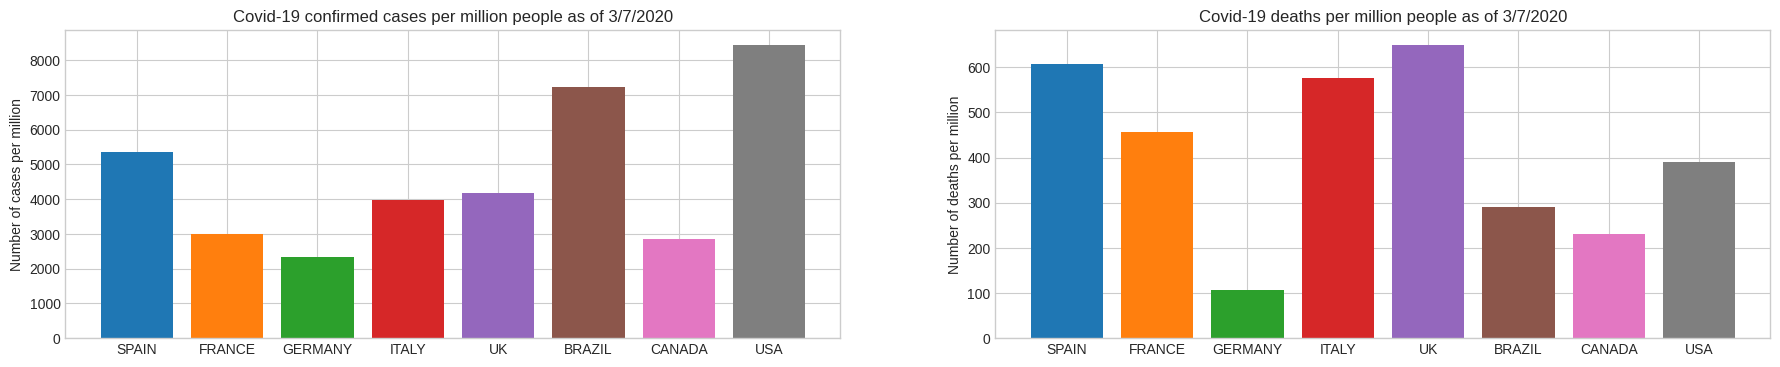

In [18]:
fig, ax = plt.subplots(1,2, figsize=(22,4))

# Chart 1: cases per million
for x in df_cases.columns:
  ax[0].bar(x, df_cases_per_million[x].tail(1))
ax[0].set_ylabel('Number of cases per million')
ax[0].set_title('Covid-19 confirmed cases per million people as of ' + last_date)

# Chart 2: deaths per million 
for x in df_cases.columns:
  ax[1].bar(x, df_deaths_per_million[x].tail(1))
ax[1].set_ylabel('Number of deaths per million')
ax[1].set_title('Covid-19 deaths per million people as of ' + last_date)

plt.show()

Here the analysis needs to be taken into parts:

1. Firstly, we have the Europe mainland countries (Spain, France, Germany and Italy) which have already gone past the peak of the first (and hopefully only) outbreak of covid-19. This means that their figures of cumulative confirmed cases and deaths should not be growing too much.
2. UK is not far behind but as it can be clearly seen in the cases evolution charts above, UK is still climbing the left side of the bell of active cases. So its figures have some way to go up.
3. Then we have the American countries, where Brazil and USA have been hit particularly hard, and are still growing fast. Canada's impact is significant too, although not comparable to its Southerner neighbours, and its active cases curve shows it's already past the peak.
4. And finally, Iran which shows a double hump curve of active cases, whilst showing totals of cases and deaths numbers comparable to Germany, and Australia which has somehow managed to evade the big hit but is now experiencing a new increase in active cases.

## Calculate more variables: growth rates

So far I have been working with the following variables:

- measured variables:
    - confirmed cases, 
    - recovered 
    - deaths
- computed variables:
    - active cases
    - mortality

It is also interesting from an investigative perspective to calculate the daily variation of some of these variables, that is their **rate of growth**, which tells us how fast the variables they derive from are changing. 

The daily variation can be computed by substracting the number of confirmed cases (or deaths or active cases) on day t-1 from the number of cases on day t. 

I will do so for three of the above, resulting in the following three new variables:

- new computed variables:
    - daily variation of cases
    - daily variation of deaths
    - daily variation of active cases 

In [19]:
# Create new dataframes with daily variation of confirmed cases, deaths and active cases
df_cases_diff = pd.DataFrame(index=df_cases.index, columns=df_cases.columns)
df_deaths_diff = pd.DataFrame(index=df_deaths.index, columns=df_deaths.columns)
df_active_diff = pd.DataFrame(index=df_active.index, columns=df_active.columns)

for x in df_cases_diff.columns:
  df_cases_diff[x] = df_cases[x].diff()
  df_deaths_diff[x] = df_deaths[x].diff()
  df_active_diff[x] = df_active[x].diff()

df_cases_diff.fillna(value=0, inplace=True)
df_deaths_diff.fillna(value=0, inplace=True)
df_active_diff.fillna(value=0, inplace=True)

## Growth rates: individual country plots  

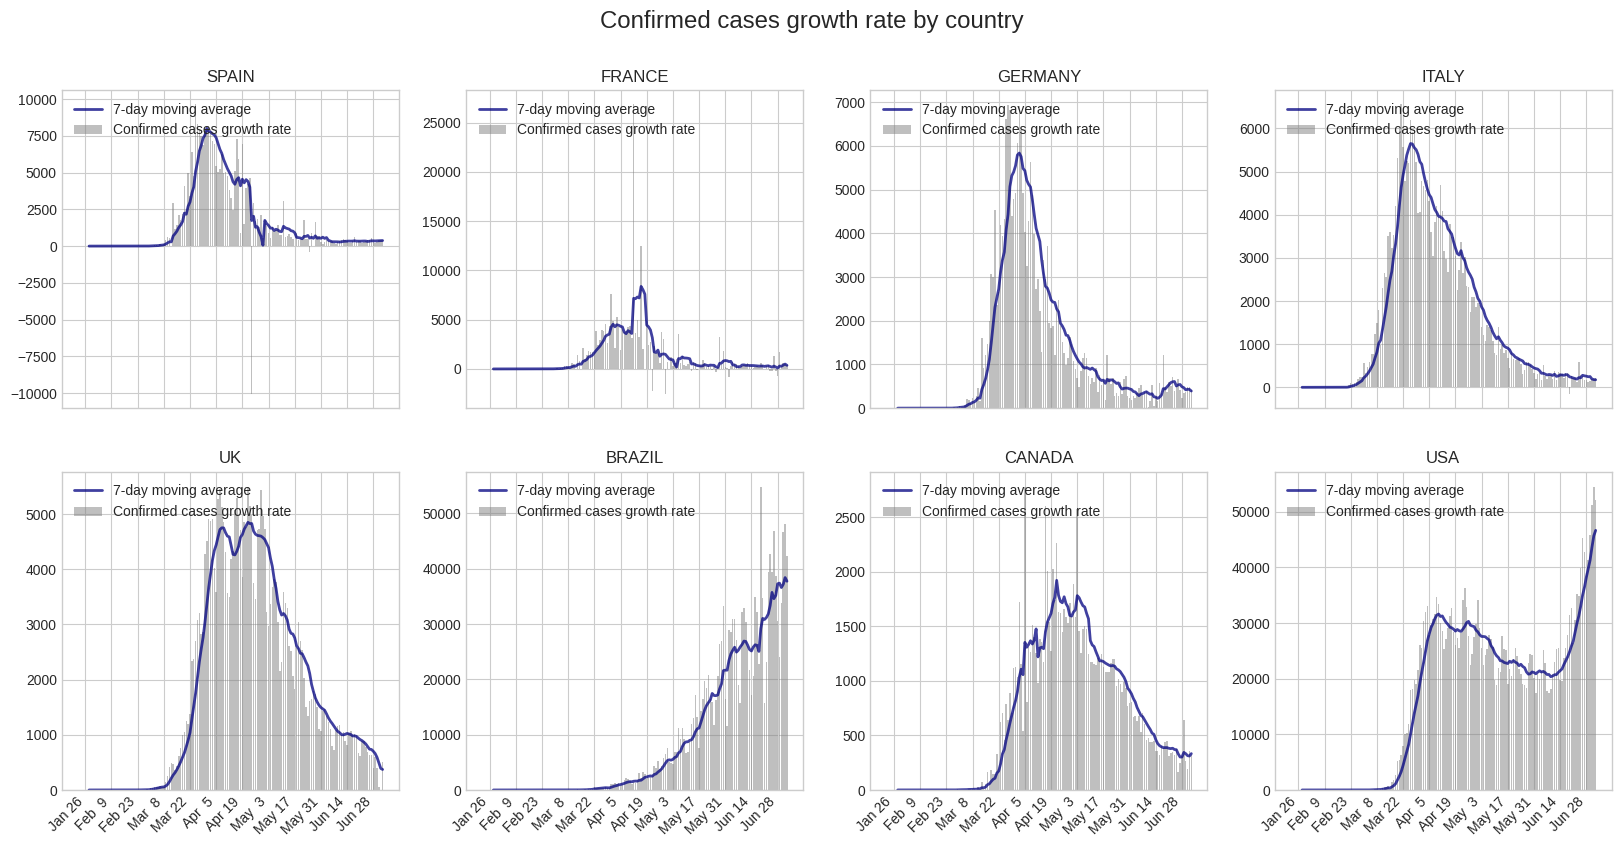

In [20]:
# Evolution of covid-19 cases: confirmed cases growth rate
fig1, ax1 = plt.subplots(2,4, figsize=(20,10))
fig1.subplots_adjust(top=0.90)
i = 0
j = 0
for x in df_cases_diff.columns:
  ax1[i,j].set_title(x)
  ax1[i,j].xaxis.set_major_formatter(my_date_fmt)
  ax1[i,j].xaxis.set_major_locator(plt.MultipleLocator(14)) 
  ax1[i,j].bar(df_cases_diff.index, df_cases_diff[x], color='grey', alpha=0.5, label='Confirmed cases growth rate')
  ax1[i,j].plot(df_cases_diff.index, df_cases_diff[x].rolling(window=7).mean(), color='navy', alpha=0.75, linewidth=2, label='7-day moving average')
  ax1[i,j].legend(loc='upper left', fontsize='medium')
  if j<3:
    j = j + 1
  else:
    j = 0
    i = i + 1

fig1.suptitle('Confirmed cases growth rate by country', fontsize='xx-large')  
fig1.autofmt_xdate(rotation=45, ha='right')
plt.show()

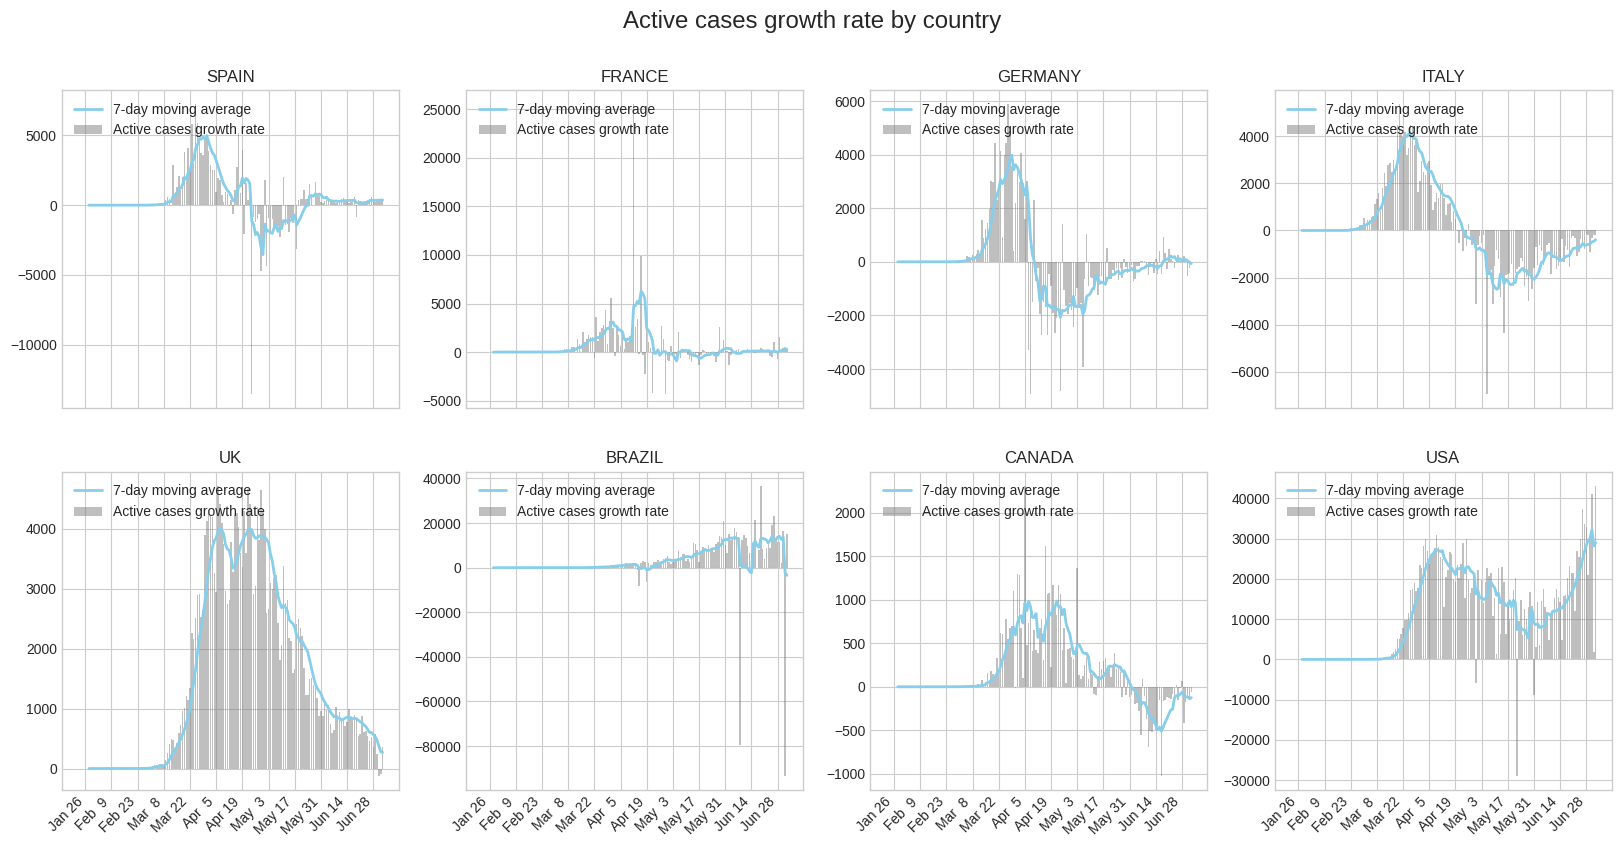

In [21]:
# Evolution of covid-19 cases: active cases growth rate 
fig2, ax2 = plt.subplots(2,4, figsize=(20,10))
fig2.subplots_adjust(top=0.90)
i = 0
j = 0
for x in df_active_diff.columns:
  ax2[i,j].set_title(x)
  ax2[i,j].xaxis.set_major_formatter(my_date_fmt)
  ax2[i,j].xaxis.set_major_locator(plt.MultipleLocator(14)) 
  ax2[i,j].bar(df_active_diff.index, df_active_diff[x], color='grey', alpha=0.5, label='Active cases growth rate')
  ax2[i,j].plot(df_active_diff.index, df_active_diff[x].rolling(window=7).mean(), color='skyblue', linewidth=2, label='7-day moving average')
  ax2[i,j].legend(loc='upper left', fontsize='medium')
  if j<3:
    j = j + 1
  else:
    j = 0
    i = i + 1

fig2.suptitle('Active cases growth rate by country', fontsize='xx-large')  
fig2.autofmt_xdate(rotation=45, ha='right')
plt.show()

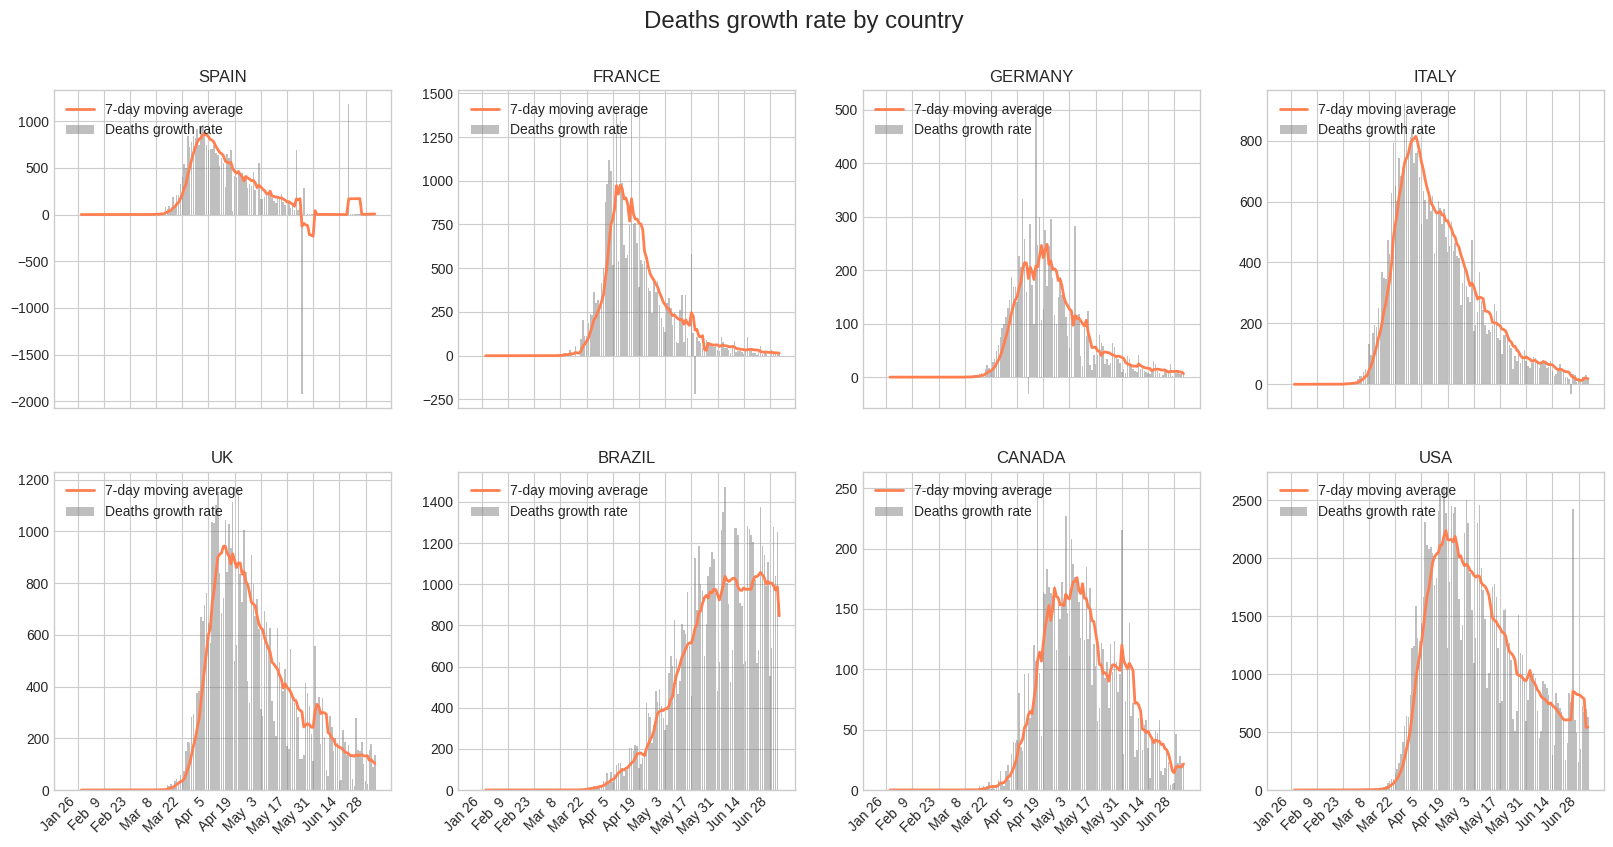

In [22]:
# Evolution of covid-19 cases: deaths growth rate
fig3, ax3 = plt.subplots(2,4, figsize=(20,10))
fig3.subplots_adjust(top=0.90)
i = 0
j = 0
for x in df_cases.columns:
  ax3[i,j].set_title(x)
  ax3[i,j].xaxis.set_major_formatter(my_date_fmt)
  ax3[i,j].xaxis.set_major_locator(plt.MultipleLocator(14)) 
  ax3[i,j].bar(df_deaths_diff.index, df_deaths_diff[x], color='grey', alpha=0.5, label='Deaths growth rate')
  ax3[i,j].plot(df_deaths_diff.index, df_deaths_diff[x].rolling(window=7).mean(), color='coral', linewidth=2, label='7-day moving average')
  ax3[i,j].legend(loc='upper left', fontsize='medium')
  if j<3:
    j = j + 1
  else:
    j = 0
    i = i + 1

fig3.suptitle('Deaths growth rate by country', fontsize='xx-large')  
fig3.autofmt_xdate(rotation=45, ha='right')
plt.show()

## Prediction models with recurrent neural network

The following variables will be modeled with a RNN:
- RNN type A: cumulative variables
    - total number of confirmed cases
    - total number of deaths
- RNN type B: calculated variables
    - active cases
- RNN type C: daily variations
    - confirmed cases growth rate
    - deaths growth rate
    - active cases growth rate

The reason for doing this differentiation is the following.

The first two variables are cumulative (hence always increasing) and with a known exponential growth rate at the beginning and before some virus containment measures are taken (confinement, mask wearing, etc.). They have then a relatively small variability and typically tend asymptotically to a top (end of pandemic) value. I will try a LSTM 2-layer RNN to model these two variables.

Now, for type B, the active cases variable is calculated as confirmed - deaths - recovered. The behaviour of this variable depends on the independent variables deaths, recovered and confirmed cases (which in turn are dependent on many other, exterrnal factors not taken into consideration in the model). Ideally, the active cases should display a bell-shaped curve. What seems evident is this is not a rapidly changing variable (so it is a low-frequency signal). For this type B RNN I will use a 3-layer LSTM network.

Finally, for type C, the model will be predicting more rapidly changing signals, with both low and higher frequency information. I will use here the most complex RNN model with a 3-layer LSTM network with a comparatively higher number of cells.

All in all, the source data contains some outliers which I have chosen not to remove but that will undoubtly affect the model's prediction ability. These peaks and drops are most likely attributeable to methodological changes and / or backlogs.

## Prediction of confirmed cases and deaths (RNN type A)

In [23]:
# Model parameters - network Type A (cumulative variables: confirmed cases and deaths)

# Number of samples
NBR_SAMPLES = df_cases.shape[0]

# Number of features Xi 
NBR_FEATURES = len(df_cases.columns)

# Number of predictions (56 days, 8 semanas)
NBR_PREDICTIONS = 56 

# Size ot TRAIN and TEST samples
NBR_TRAIN_SAMPLES = NBR_SAMPLES - NBR_PREDICTIONS
NBR_TEST_SAMPLES = NBR_SAMPLES - NBR_TRAIN_SAMPLES

# Number of input steps [x(t-1), x(t-2), x(t-3)...] to predict an output y(t)
TIME_STEPS = 8

# Number of overlapping training sequences of TIME_STEPS
BATCH_SIZE = 8

# Number of training cycles
EPOCHS = 100

print('RNN Type A model parameters (cumulative variables: confirmed cases and deaths)')
print('..........................................')
print()
print('NBR_SAMPLES: ', NBR_SAMPLES)
print('NBR_PREDICTIONS: ', NBR_PREDICTIONS)
print('NBR_TRAIN_SAMPLES: ', NBR_TRAIN_SAMPLES)
print('NBR_TEST_SAMPLES: ', NBR_TEST_SAMPLES)
print()
print('NBR_FEATURES: ', NBR_FEATURES)
print('TIME_STEPS:', TIME_STEPS)
print('BATCH_SIZE: ', BATCH_SIZE)
print('EPOCHS: ', EPOCHS)

RNN Type A model parameters (cumulative variables: confirmed cases and deaths)
..........................................

NBR_SAMPLES:  164
NBR_PREDICTIONS:  56
NBR_TRAIN_SAMPLES:  108
NBR_TEST_SAMPLES:  56

NBR_FEATURES:  8
TIME_STEPS: 8
BATCH_SIZE:  8
EPOCHS:  100


In [24]:
# Split dataset into test and train subsets
# Total (confirmed) cases
df_cases_train = df_cases.iloc[0:NBR_TRAIN_SAMPLES, 0:NBR_FEATURES] 
df_cases_test = df_cases.iloc[NBR_TRAIN_SAMPLES:, 0:NBR_FEATURES]
# Deaths growth rate
df_deaths_train = df_deaths.iloc[0:NBR_TRAIN_SAMPLES, 0:NBR_FEATURES] 
df_deaths_test = df_deaths.iloc[NBR_TRAIN_SAMPLES:, 0:NBR_FEATURES]

In [25]:
# Normalize test and train data (range: 0 .. +1)
from sklearn.preprocessing import MinMaxScaler
sc1 = MinMaxScaler(feature_range = (0, 1))
sc2 = MinMaxScaler(feature_range = (0, 1))

sc1.fit(df_cases_train)
sc1_df_train = sc1.transform(df_cases_train)
sc1_df_test = sc1.transform(df_cases_test)

sc2.fit(df_deaths_train)
sc2_df_train = sc2.transform(df_deaths_train)
sc2_df_test = sc2.transform(df_deaths_test)

In [26]:
# Prepare training sequences

# Confirmed cases
X_train_1 = []
y_train_1 = []
for i in range(TIME_STEPS, NBR_TRAIN_SAMPLES):
    X_train_1.append(sc1_df_train[i-TIME_STEPS:i, 0:NBR_FEATURES])
    y_train_1.append(sc1_df_train[i, 0:NBR_FEATURES])
X_train_1, y_train_1 = np.array(X_train_1), np.array(y_train_1)
X_train_1 = np.reshape(X_train_1, (X_train_1.shape[0], X_train_1.shape[1], NBR_FEATURES))

# Deaths 
X_train_2 = []
y_train_2 = []
for i in range(TIME_STEPS, NBR_TRAIN_SAMPLES):
    X_train_2.append(sc2_df_train[i-TIME_STEPS:i, 0:NBR_FEATURES])
    y_train_2.append(sc2_df_train[i, 0:NBR_FEATURES])
X_train_2, y_train_2 = np.array(X_train_2), np.array(y_train_2)
X_train_2 = np.reshape(X_train_2, (X_train_2.shape[0], X_train_2.shape[1], NBR_FEATURES))

In [27]:
# Build LSTM (Long Short-Term Memory) recurrent neural networks for cumulative variables (RNN type A) 
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout 

# Initialize structure, 2 layers LSTM, cumulative number of confirmed cases
RNN_A_1 = Sequential()

# Build layers:
# 2 LSTM layers with dropout
# Nbr Feaures output dense layers
RNN_A_1.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train_1.shape[1], NBR_FEATURES)))
RNN_A_1.add(Dropout(0.25))
RNN_A_1.add(LSTM(units = 64))
RNN_A_1.add(Dropout(0.25))
RNN_A_1.add(Dense(units = NBR_FEATURES))

RNN_A_1.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 8, 128)            70144     
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 520       
Total params: 120,072
Trainable params: 120,072
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Initialize structure, 2 layers LSTM, cumulative number of deaths 
RNN_A_2 = Sequential()

# Build layers:
# 2 LSTM layers with dropout
# Nbr Feaures output dense layers
RNN_A_2.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train_2.shape[1], NBR_FEATURES)))
RNN_A_2.add(Dropout(0.25))
RNN_A_2.add(LSTM(units = 64))
RNN_A_2.add(Dropout(0.25))
RNN_A_2.add(Dense(units = NBR_FEATURES))

RNN_A_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 8, 128)            70144     
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 128)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 520       
Total params: 120,072
Trainable params: 120,072
Non-trainable params: 0
_________________________________________________________________


In [29]:
%%time
# Compile and train the RNN
RNN_A_1.compile(optimizer = 'adam', loss = 'mean_squared_error')
RNN_A_1.fit(X_train_1, y_train_1, epochs = EPOCHS, batch_size = BATCH_SIZE)

Epoch 1/100
100/100 [==============================] - 2s 21ms/step - loss: 0.0896
Epoch 2/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0227
Epoch 3/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0155
Epoch 4/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 5/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 6/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 7/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 8/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 9/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch 10/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 11/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0083
Epoch 12/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 13/100

In [30]:
%%time
# Compile and train the RNN
RNN_A_2.compile(optimizer = 'adam', loss = 'mean_squared_error')
RNN_A_2.fit(X_train_2, y_train_2, epochs = EPOCHS, batch_size = BATCH_SIZE)

Epoch 1/100
100/100 [==============================] - 1s 11ms/step - loss: 0.0889
Epoch 2/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0190
Epoch 3/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0112
Epoch 4/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 5/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 6/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 7/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0080
Epoch 8/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0071
Epoch 9/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0066
Epoch 10/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0059
Epoch 11/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0064
Epoch 12/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 13/100

In [31]:
# Use now the full dataframes to predict / evaluate the model)
df_full_1 = df_cases.iloc[:, 0:NBR_FEATURES]
df_full_2 = df_deaths.iloc[:, 0:NBR_FEATURES]

# Scale full dataset (use same scaler fitted with train data earlier)
df_full_1 = sc1.transform(df_full_1)
df_full_2 = sc2.transform(df_full_2)

X_test_1 = []
X_test_2 = []

for i in range(NBR_TRAIN_SAMPLES, NBR_SAMPLES):
    X_test_1.append(df_full_1[i-TIME_STEPS:i, 0:NBR_FEATURES])
    X_test_2.append(df_full_2[i-TIME_STEPS:i, 0:NBR_FEATURES]) 
      
# Reshape arrrays
X_test_1 = np.array(X_test_1)
X_test_1 = np.reshape(X_test_1, (X_test_1.shape[0], X_test_1.shape[1], NBR_FEATURES))
X_test_2 = np.array(X_test_2)
X_test_2 = np.reshape(X_test_2, (X_test_2.shape[0], X_test_2.shape[1], NBR_FEATURES))

# Make predictions
predicted_values_1 = RNN_A_1.predict(X_test_1)
predicted_values_1 = sc1.inverse_transform(predicted_values_1)
predicted_values_2 = RNN_A_2.predict(X_test_2)
predicted_values_2 = sc2.inverse_transform(predicted_values_2)

In [32]:
# Add columns with predictions
i = 0
for x in df_cases.columns:
  df_cases_test[x + '_PREDICTED'] = predicted_values_1[:,i]
  df_deaths_test[x + '_PREDICTED'] = predicted_values_2[:,i]
  i = i+1

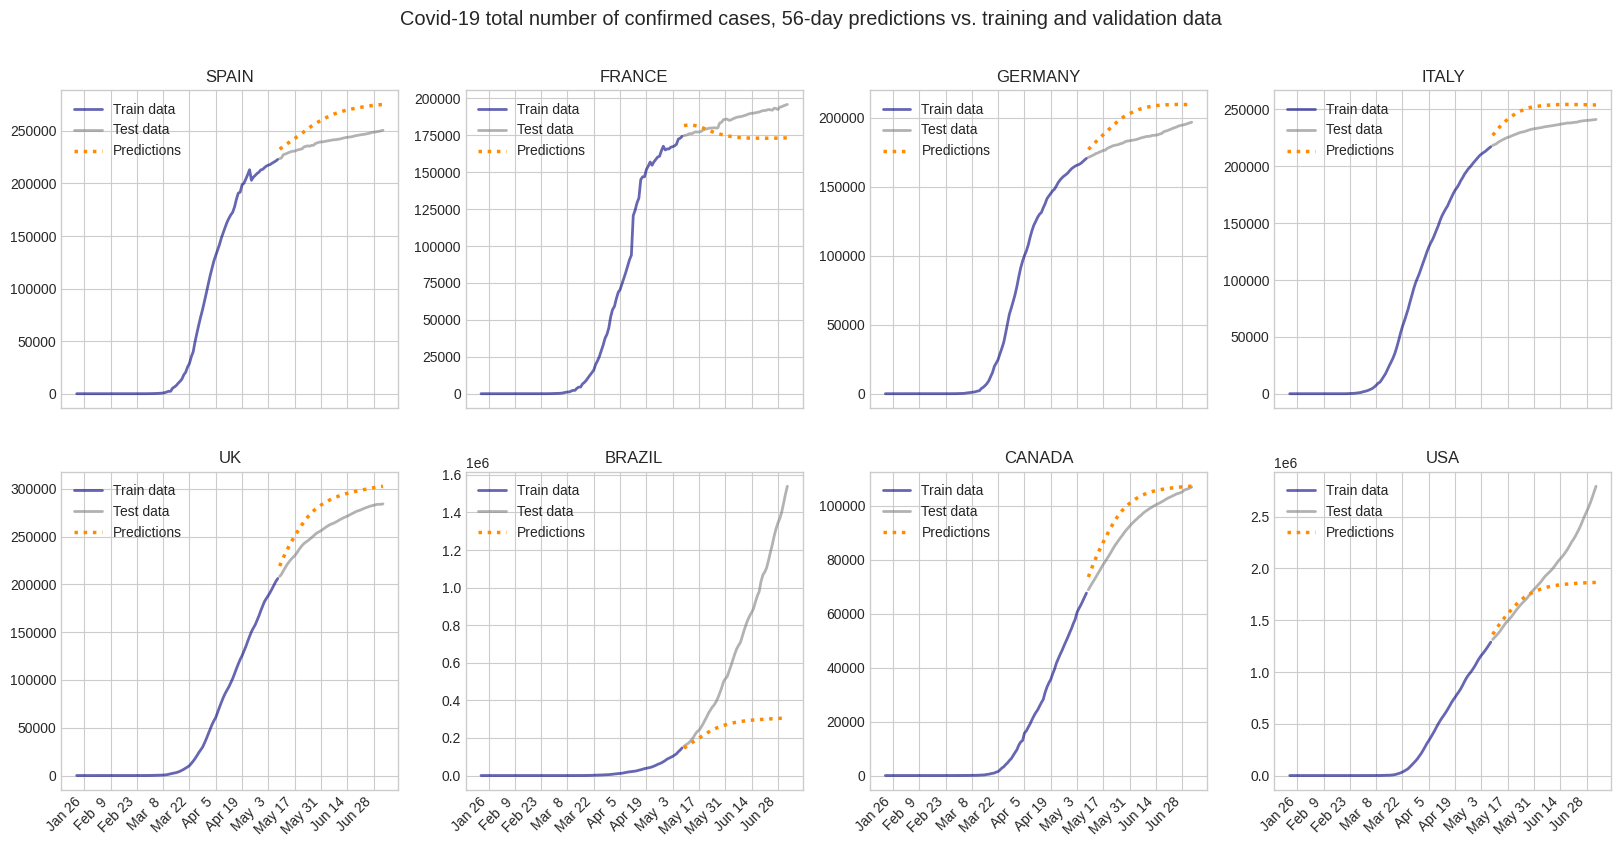

In [33]:
# Plotting actual training and test data vs. predictions: confirmed cases
fig1, ax1 = plt.subplots(2,4, figsize=(20,10))
fig1.subplots_adjust(top=0.90)
i = 0
j = 0
for x in df_cases.columns:
  ax1[i,j].set_title(x)
  ax1[i,j].xaxis.set_major_formatter(my_date_fmt)
  ax1[i,j].xaxis.set_major_locator(plt.MultipleLocator(14))
  ax1[i,j].plot(df_cases_train.index, df_cases_train[x], lw=2, color='navy', alpha=0.6, label='Train data')
  ax1[i,j].plot(df_cases_test.index, df_cases_test[x], lw=2, color='grey', alpha=0.6, label='Test data')
  ax1[i,j].plot(df_cases_test.index, df_cases_test[x + '_PREDICTED'], lw=2.5, linestyle=':', color='darkorange', label='Predictions')
  ax1[i,j].legend(loc='upper left', fontsize='medium')
  if j < 3:
    j = j + 1
  else:
    j = 0
    i = i + 1

fig1.suptitle('Covid-19 total number of confirmed cases, ' + str(NBR_PREDICTIONS) + '-day predictions vs. training and validation data', fontsize='x-large')  
fig1.autofmt_xdate(rotation=45, ha='right')
plt.show()

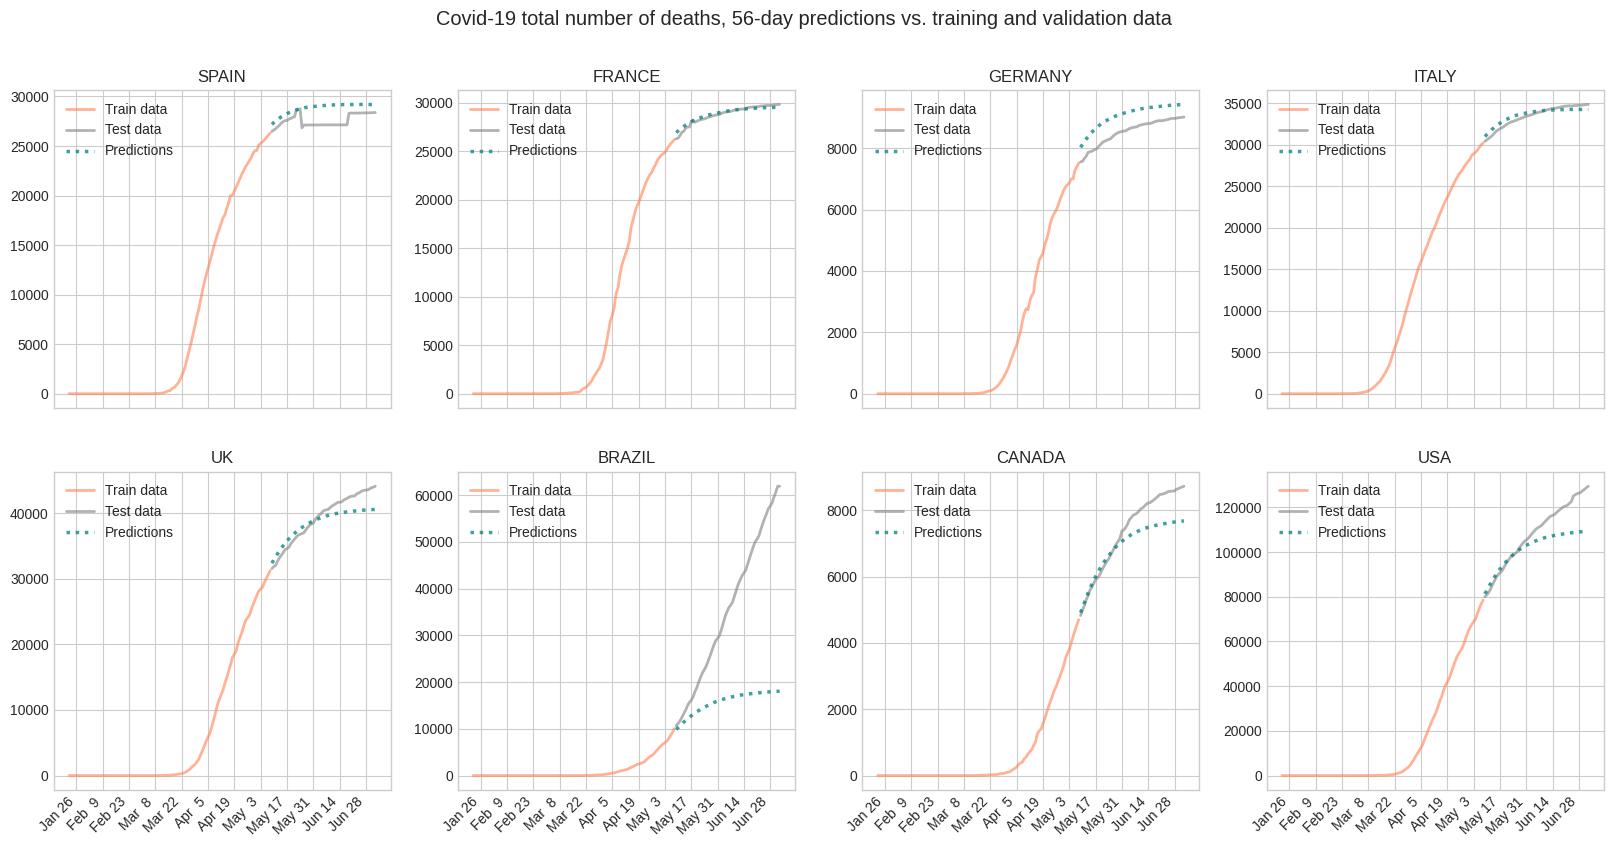

In [34]:
# Plotting actual training and test data vs. predictions: total number of deaths
fig2, ax2 = plt.subplots(2,4, figsize=(20,10))
fig2.subplots_adjust(top=0.90)
i = 0
j = 0
for x in df_deaths_diff.columns:
  ax2[i,j].set_title(x)
  ax2[i,j].xaxis.set_major_formatter(my_date_fmt)
  ax2[i,j].xaxis.set_major_locator(plt.MultipleLocator(14))
  ax2[i,j].plot(df_deaths_train.index, df_deaths_train[x], linewidth=2, color='coral', alpha=0.6, label='Train data')
  ax2[i,j].plot(df_deaths_test.index, df_deaths_test[x], linewidth=2, color='gray', alpha=0.6, label='Test data')
  ax2[i,j].plot(df_deaths_test.index, df_deaths_test[x + '_PREDICTED'], linewidth=2.5, linestyle=':', alpha=0.75, color='teal', label='Predictions')
  ax2[i,j].legend(loc='upper left', fontsize='medium')
  if j < 3:
    j = j + 1
  else:
    j = 0
    i = i + 1

fig2.suptitle('Covid-19 total number of deaths, ' + str(NBR_PREDICTIONS) + '-day predictions vs. training and validation data', fontsize='x-large')  
fig2.autofmt_xdate(rotation=45, ha='right')
plt.show()

## Prediction of active cases (RNN type B)

In [35]:
# Model parameters - network Type B (calculated variable: active cases)

# Number of samples
NBR_SAMPLES = df_active.shape[0]

# Number of features Xi 
NBR_FEATURES = len(df_active.columns)

# Number of predictions (28 days)
NBR_PREDICTIONS = 28 

# Size ot TRAIN and TEST samples
NBR_TRAIN_SAMPLES = NBR_SAMPLES - NBR_PREDICTIONS
NBR_TEST_SAMPLES = NBR_SAMPLES - NBR_TRAIN_SAMPLES

# Number of input steps [x(t-1), x(t-2), x(t-3)...] to predict an output y(t)
TIME_STEPS = 8

# Number of overlapping training sequences of TIME_STEPS
BATCH_SIZE = 8

# Number of training cycles
EPOCHS = 100

print('RNN Type B model parameters (active cases)')
print('..........................................')
print()
print('NBR_SAMPLES: ', NBR_SAMPLES)
print('NBR_PREDICTIONS: ', NBR_PREDICTIONS)
print('NBR_TRAIN_SAMPLES: ', NBR_TRAIN_SAMPLES)
print('NBR_TEST_SAMPLES: ', NBR_TEST_SAMPLES)
print()
print('NBR_FEATURES: ', NBR_FEATURES)
print('TIME_STEPS:', TIME_STEPS)
print('BATCH_SIZE: ', BATCH_SIZE)
print('EPOCHS: ', EPOCHS)

RNN Type B model parameters (active cases)
..........................................

NBR_SAMPLES:  164
NBR_PREDICTIONS:  28
NBR_TRAIN_SAMPLES:  136
NBR_TEST_SAMPLES:  28

NBR_FEATURES:  8
TIME_STEPS: 8
BATCH_SIZE:  8
EPOCHS:  100


In [36]:
# Split dataset into test and train subsets
# Active cases
df_active_train = df_active.iloc[0:NBR_TRAIN_SAMPLES, 0:NBR_FEATURES] 
df_active_test = df_active.iloc[NBR_TRAIN_SAMPLES:, 0:NBR_FEATURES]

In [37]:
# Normalize test and train data (range: 0 .. +1)
from sklearn.preprocessing import MinMaxScaler
sc1 = MinMaxScaler(feature_range = (0, 1))

sc1.fit(df_active_train)
sc1_df_train = sc1.transform(df_active_train)
sc1_df_test = sc1.transform(df_active_test)

In [38]:
# Prepare training sequences

# Actived cases
X_train_1 = []
y_train_1 = []
for i in range(TIME_STEPS, NBR_TRAIN_SAMPLES):
    X_train_1.append(sc1_df_train[i-TIME_STEPS:i, 0:NBR_FEATURES])
    y_train_1.append(sc1_df_train[i, 0:NBR_FEATURES])
X_train_1, y_train_1 = np.array(X_train_1), np.array(y_train_1)
X_train_1 = np.reshape(X_train_1, (X_train_1.shape[0], X_train_1.shape[1], NBR_FEATURES))

In [39]:
# Build LSTM (Long Short-Term Memory) recurrent neural network for active cases (RNN type B) 

# Initialize structure, 3 layers LSTM
RNN_B_1 = Sequential()

# Build layers:
# 3 LSTM layers with dropout
# Nbr Feaures output dense layers
RNN_B_1.add(LSTM(units = 256, return_sequences = True, input_shape = (X_train_1.shape[1], NBR_FEATURES)))
RNN_B_1.add(Dropout(0.25))
RNN_B_1.add(LSTM(units = 256, return_sequences=True))
RNN_B_1.add(Dropout(0.25))
RNN_B_1.add(LSTM(units = 256))
RNN_B_1.add(Dropout(0.25))
RNN_B_1.add(Dense(units = NBR_FEATURES))

RNN_B_1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 8, 256)            271360    
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 256)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 8, 256)            525312    
_________________________________________________________________
dropout_6 (Dropout)          (None, 8, 256)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                

In [40]:
%%time
# Compile and train the RNN
RNN_B_1.compile(optimizer = 'adam', loss = 'mean_squared_error')
RNN_B_1.fit(X_train_1, y_train_1, epochs = EPOCHS, batch_size = BATCH_SIZE)

Epoch 1/100
128/128 [==============================] - 2s 13ms/step - loss: 0.0529
Epoch 2/100
128/128 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 3/100
128/128 [==============================] - 0s 3ms/step - loss: 0.0111
Epoch 4/100
128/128 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 5/100
128/128 [==============================] - 0s 3ms/step - loss: 0.0066
Epoch 6/100
128/128 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 7/100
128/128 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 8/100
128/128 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 9/100
128/128 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 10/100
128/128 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 11/100
128/128 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 12/100
128/128 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 13/100

In [41]:
# Use now the full dataframes to predict / evaluate the model
df_full_1 = df_active.iloc[:, 0:NBR_FEATURES]

# Scale full dataset (use same scaler fitted with train data earlier)
df_full_1 = sc1.transform(df_full_1)

X_test_1 = []

for i in range(NBR_TRAIN_SAMPLES, NBR_SAMPLES):
    X_test_1.append(df_full_1[i-TIME_STEPS:i, 0:NBR_FEATURES])
        
# Reshape arrrays
X_test_1 = np.array(X_test_1)
X_test_1 = np.reshape(X_test_1, (X_test_1.shape[0], X_test_1.shape[1], NBR_FEATURES))

# Make predictions
predicted_values_1 = RNN_B_1.predict(X_test_1)
predicted_values_1 = sc1.inverse_transform(predicted_values_1)

In [42]:
# Add columns with predictions
i = 0
for x in df_active.columns:
  df_active_test[x + '_PREDICTED'] = predicted_values_1[:,i]
  i = i+1

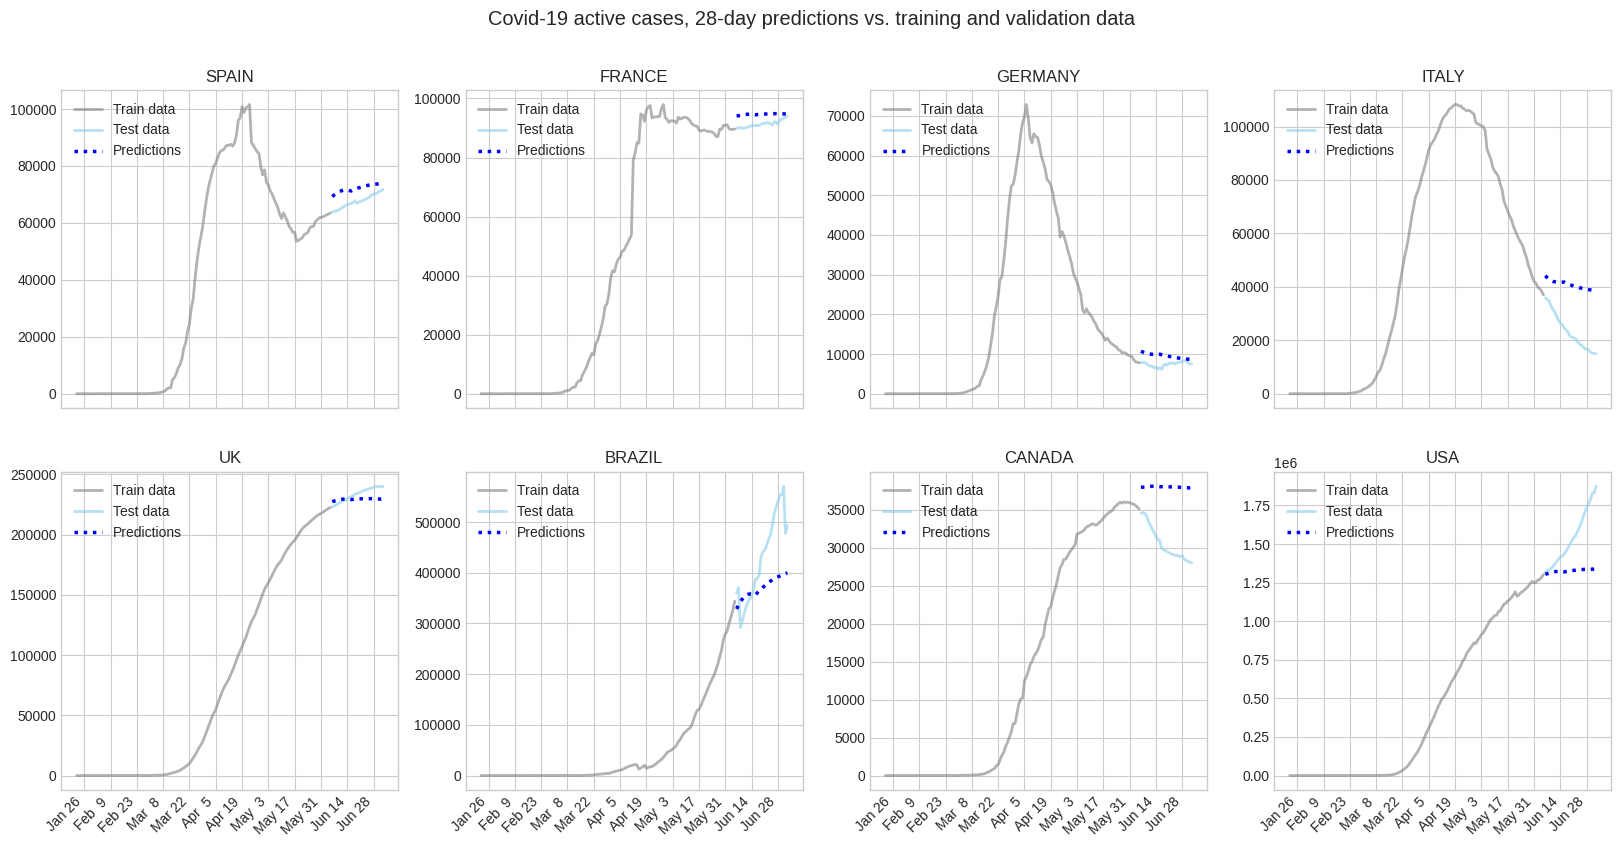

In [43]:
# Plotting actual training and test data vs. predictions: confirmed cases growth rate
fig1, ax1 = plt.subplots(2,4, figsize=(20,10))
fig1.subplots_adjust(top=0.90)
i = 0
j = 0
for x in df_active.columns:
  ax1[i,j].set_title(x)
  ax1[i,j].xaxis.set_major_formatter(my_date_fmt)
  ax1[i,j].xaxis.set_major_locator(plt.MultipleLocator(14))
  ax1[i,j].plot(df_active_train.index, df_active_train[x], lw=2, color='gray', alpha=0.6, label='Train data')
  ax1[i,j].plot(df_active_test.index, df_active_test[x], lw=2, color='skyblue', alpha=0.6, label='Test data')
  ax1[i,j].plot(df_active_test.index, df_active_test[x + '_PREDICTED'], lw=2.5, linestyle=':', color='blue', label='Predictions')
  ax1[i,j].legend(loc='upper left', fontsize='medium')
  if j < 3:
    j = j + 1
  else:
    j = 0
    i = i + 1

fig1.suptitle('Covid-19 active cases, ' + str(NBR_PREDICTIONS) + '-day predictions vs. training and validation data', fontsize='x-large')  
fig1.autofmt_xdate(rotation=45, ha='right')
plt.show()

## Prediction of growth rates (RNN type C)

In [44]:
# Model parameters - network Type C (growth rates)
# Daily variation of cases (daily new cases)
# Daily variation of deaths (daily new deaths)
# Daily variation of active cases

# Number of samples
NBR_SAMPLES = df_cases_diff.shape[0]

# Number of features Xi 
NBR_FEATURES = len(df_cases_diff.columns)

# Number of predictions (28 days)
NBR_PREDICTIONS = 28 

# Size ot TRAIN and TEST samples
NBR_TRAIN_SAMPLES = NBR_SAMPLES - NBR_PREDICTIONS
NBR_TEST_SAMPLES = NBR_SAMPLES - NBR_TRAIN_SAMPLES

# Number of input steps [x(t-1), x(t-2), x(t-3)...] to predict an output y(t)
TIME_STEPS = 8

# Number of overlapping training sequences of TIME_STEPS
BATCH_SIZE = 8

# Number of training cycles
EPOCHS = 150

print('RNN Type C model parameters (growth rates)')
print('..........................................')
print()
print('NBR_SAMPLES: ', NBR_SAMPLES)
print('NBR_PREDICTIONS: ', NBR_PREDICTIONS)
print('NBR_TRAIN_SAMPLES: ', NBR_TRAIN_SAMPLES)
print('NBR_TEST_SAMPLES: ', NBR_TEST_SAMPLES)
print()
print('NBR_FEATURES: ', NBR_FEATURES)
print('TIME_STEPS:', TIME_STEPS)
print('BATCH_SIZE: ', BATCH_SIZE)
print('EPOCHS: ', EPOCHS)

RNN Type C model parameters (growth rates)
..........................................

NBR_SAMPLES:  164
NBR_PREDICTIONS:  28
NBR_TRAIN_SAMPLES:  136
NBR_TEST_SAMPLES:  28

NBR_FEATURES:  8
TIME_STEPS: 8
BATCH_SIZE:  8
EPOCHS:  150


In [45]:
# Split dataset into test and train subsets
# Total (confirmed) cases growth rate
df_cases_diff_train = df_cases_diff.iloc[0:NBR_TRAIN_SAMPLES, 0:NBR_FEATURES] 
df_cases_diff_test = df_cases_diff.iloc[NBR_TRAIN_SAMPLES:, 0:NBR_FEATURES]
# Deaths growth rate
df_deaths_diff_train = df_deaths_diff.iloc[0:NBR_TRAIN_SAMPLES, 0:NBR_FEATURES] 
df_deaths_diff_test = df_deaths_diff.iloc[NBR_TRAIN_SAMPLES:, 0:NBR_FEATURES]
# Active cases growth rate
df_active_diff_train = df_active_diff.iloc[0:NBR_TRAIN_SAMPLES, 0:NBR_FEATURES] 
df_active_diff_test = df_active_diff.iloc[NBR_TRAIN_SAMPLES:, 0:NBR_FEATURES]

In [46]:
# Normalize test and train data (range: -1 .. +1)
from sklearn.preprocessing import MinMaxScaler
sc1 = MinMaxScaler(feature_range = (-1, 1))
sc2 = MinMaxScaler(feature_range = (-1, 1))
sc3 = MinMaxScaler(feature_range = (-1, 1))

sc1.fit(df_cases_diff_train)
sc1_df_train = sc1.transform(df_cases_diff_train)
sc1_df_test = sc1.transform(df_cases_diff_test)

sc2.fit(df_deaths_diff_train)
sc2_df_train = sc2.transform(df_deaths_diff_train)
sc2_df_test = sc2.transform(df_deaths_diff_test)

sc3.fit(df_active_diff_train)
sc3_df_train = sc3.transform(df_active_diff_train)
sc3_df_test = sc3.transform(df_active_diff_test)

In [47]:
# Prepare training sequences

# Confirmed cases growth rate
X_train_1 = []
y_train_1 = []
for i in range(TIME_STEPS, NBR_TRAIN_SAMPLES):
    X_train_1.append(sc1_df_train[i-TIME_STEPS:i, 0:NBR_FEATURES])
    y_train_1.append(sc1_df_train[i, 0:NBR_FEATURES])
X_train_1, y_train_1 = np.array(X_train_1), np.array(y_train_1)
X_train_1 = np.reshape(X_train_1, (X_train_1.shape[0], X_train_1.shape[1], NBR_FEATURES))

# Deaths growth rate
X_train_2 = []
y_train_2 = []
for i in range(TIME_STEPS, NBR_TRAIN_SAMPLES):
    X_train_2.append(sc2_df_train[i-TIME_STEPS:i, 0:NBR_FEATURES])
    y_train_2.append(sc2_df_train[i, 0:NBR_FEATURES])
X_train_2, y_train_2 = np.array(X_train_2), np.array(y_train_2)
X_train_2 = np.reshape(X_train_2, (X_train_2.shape[0], X_train_2.shape[1], NBR_FEATURES))

# Active casee growth rate
X_train_3 = []
y_train_3 = []
for i in range(TIME_STEPS, NBR_TRAIN_SAMPLES):
    X_train_3.append(sc3_df_train[i-TIME_STEPS:i, 0:NBR_FEATURES])
    y_train_3.append(sc3_df_train[i, 0:NBR_FEATURES])
X_train_3, y_train_3 = np.array(X_train_3), np.array(y_train_3)
X_train_3 = np.reshape(X_train_3, (X_train_3.shape[0], X_train_3.shape[1], NBR_FEATURES))

In [48]:
# Build LSTM (Long Short-Term Memory) recurrent neural networks (RNN type C) for growth rate variables

# Initialize structure, 3 layers LSTM
RNN1 = Sequential()

# Build layers:
# 3 LSTM layers with dropout
# Nbr Feaures output dense layers
RNN1.add(LSTM(units = 1024, return_sequences = True, input_shape = (X_train_1.shape[1], NBR_FEATURES)))
RNN1.add(Dropout(0.4))
RNN1.add(LSTM(units = 512, return_sequences=True))
RNN1.add(Dropout(0.25))
RNN1.add(LSTM(units = 256))
RNN1.add(Dropout(0.25))
RNN1.add(Dense(units = NBR_FEATURES))

RNN1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 8, 1024)           4231168   
_________________________________________________________________
dropout_8 (Dropout)          (None, 8, 1024)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 8, 512)            3147776   
_________________________________________________________________
dropout_9 (Dropout)          (None, 8, 512)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                

In [49]:
# Initialize structure, 3 layers LSTM
RNN2 = Sequential()

# Build layers:
# 3 LSTM layers with dropout
# Nbr Feaures output dense layers
RNN2.add(LSTM(units = 1024, return_sequences = True, input_shape = (X_train_2.shape[1], NBR_FEATURES)))
RNN2.add(Dropout(0.4))
RNN2.add(LSTM(units = 512, return_sequences=True))
RNN2.add(Dropout(0.25))
RNN2.add(LSTM(units = 256))
RNN2.add(Dropout(0.25))
RNN2.add(Dense(units = NBR_FEATURES))

RNN2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 8, 1024)           4231168   
_________________________________________________________________
dropout_11 (Dropout)         (None, 8, 1024)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 8, 512)            3147776   
_________________________________________________________________
dropout_12 (Dropout)         (None, 8, 512)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                

In [50]:
# Initialize structure, 3 layers LSTM
RNN3 = Sequential()

# Build layers:
# 3 LSTM layers with dropout
RNN3.add(LSTM(units = 1024, return_sequences = True, input_shape = (X_train_3.shape[1], NBR_FEATURES)))
RNN3.add(Dropout(0.4))
RNN3.add(LSTM(units = 512, return_sequences=True))
RNN3.add(Dropout(0.25))
RNN3.add(LSTM(units = 256))
RNN3.add(Dropout(0.25))
RNN3.add(Dense(units = NBR_FEATURES))

RNN3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 8, 1024)           4231168   
_________________________________________________________________
dropout_14 (Dropout)         (None, 8, 1024)           0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 8, 512)            3147776   
_________________________________________________________________
dropout_15 (Dropout)         (None, 8, 512)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                

In [51]:
%%time
# Compile and train the RNN
RNN1.compile(optimizer = 'adam', loss = 'mean_squared_error')
RNN1.fit(X_train_1, y_train_1, epochs = EPOCHS, batch_size = BATCH_SIZE)

Epoch 1/150
128/128 [==============================] - 2s 13ms/step - loss: 0.1364
Epoch 2/150
128/128 [==============================] - 0s 3ms/step - loss: 0.0622
Epoch 3/150
128/128 [==============================] - 0s 4ms/step - loss: 0.0457
Epoch 4/150
128/128 [==============================] - 0s 4ms/step - loss: 0.0426
Epoch 5/150
128/128 [==============================] - 0s 4ms/step - loss: 0.0447
Epoch 6/150
128/128 [==============================] - 0s 3ms/step - loss: 0.0378
Epoch 7/150
128/128 [==============================] - 0s 4ms/step - loss: 0.0374
Epoch 8/150
128/128 [==============================] - 0s 4ms/step - loss: 0.0380
Epoch 9/150
128/128 [==============================] - 0s 4ms/step - loss: 0.0414
Epoch 10/150
128/128 [==============================] - 0s 3ms/step - loss: 0.0415
Epoch 11/150
128/128 [==============================] - 0s 4ms/step - loss: 0.0394
Epoch 12/150
128/128 [==============================] - 0s 3ms/step - loss: 0.0339
Epoch 13/150

In [52]:
%%time
# Compile and train the RNN
RNN2.compile(optimizer = 'adam', loss = 'mean_squared_error')
RNN2.fit(X_train_2, y_train_2, epochs = EPOCHS, batch_size = BATCH_SIZE)

Epoch 1/150
128/128 [==============================] - 2s 13ms/step - loss: 0.1334
Epoch 2/150
128/128 [==============================] - 0s 3ms/step - loss: 0.0656
Epoch 3/150
128/128 [==============================] - 1s 6ms/step - loss: 0.0571
Epoch 4/150
128/128 [==============================] - 1s 4ms/step - loss: 0.0513
Epoch 5/150
128/128 [==============================] - 1s 5ms/step - loss: 0.0491
Epoch 6/150
128/128 [==============================] - 0s 4ms/step - loss: 0.0481
Epoch 7/150
128/128 [==============================] - 0s 3ms/step - loss: 0.0458
Epoch 8/150
128/128 [==============================] - 0s 3ms/step - loss: 0.0419
Epoch 9/150
128/128 [==============================] - 0s 3ms/step - loss: 0.0420
Epoch 10/150
128/128 [==============================] - 0s 3ms/step - loss: 0.0441
Epoch 11/150
128/128 [==============================] - 0s 4ms/step - loss: 0.0470
Epoch 12/150
128/128 [==============================] - 0s 3ms/step - loss: 0.0451
Epoch 13/150

In [53]:
%%time
# Compile and train the RNN
RNN3.compile(optimizer = 'adam', loss = 'mean_squared_error')
RNN3.fit(X_train_3, y_train_3, epochs = EPOCHS, batch_size = BATCH_SIZE)

Epoch 1/150
128/128 [==============================] - 2s 14ms/step - loss: 0.0931
Epoch 2/150
128/128 [==============================] - 0s 3ms/step - loss: 0.0495
Epoch 3/150
128/128 [==============================] - 0s 3ms/step - loss: 0.0445
Epoch 4/150
128/128 [==============================] - 0s 3ms/step - loss: 0.0446
Epoch 5/150
128/128 [==============================] - 0s 3ms/step - loss: 0.0413
Epoch 6/150
128/128 [==============================] - 0s 3ms/step - loss: 0.0415
Epoch 7/150
128/128 [==============================] - 0s 3ms/step - loss: 0.0421
Epoch 8/150
128/128 [==============================] - 0s 3ms/step - loss: 0.0443
Epoch 9/150
128/128 [==============================] - 0s 3ms/step - loss: 0.0372
Epoch 10/150
128/128 [==============================] - 0s 3ms/step - loss: 0.0387
Epoch 11/150
128/128 [==============================] - 0s 3ms/step - loss: 0.0409
Epoch 12/150
128/128 [==============================] - 0s 3ms/step - loss: 0.0373
Epoch 13/150

In [54]:
# Use now the full dataframes to predict / evaluate the model
df_full_1 = df_cases_diff.iloc[:, 0:NBR_FEATURES]
df_full_2 = df_deaths_diff.iloc[:, 0:NBR_FEATURES]
df_full_3 = df_active_diff.iloc[:, 0:NBR_FEATURES]

# Scale full dataset (use same scaler fitted with train data earlier)
df_full_1 = sc1.transform(df_full_1)
df_full_2 = sc2.transform(df_full_2)
df_full_3 = sc3.transform(df_full_3)

X_test_1 = []
X_test_2 = []
X_test_3 = []
for i in range(NBR_TRAIN_SAMPLES, NBR_SAMPLES):
    X_test_1.append(df_full_1[i-TIME_STEPS:i, 0:NBR_FEATURES])
    X_test_2.append(df_full_2[i-TIME_STEPS:i, 0:NBR_FEATURES])
    X_test_3.append(df_full_3[i-TIME_STEPS:i, 0:NBR_FEATURES])
        
# Reshape arrrays
X_test_1 = np.array(X_test_1)
X_test_1 = np.reshape(X_test_1, (X_test_1.shape[0], X_test_1.shape[1], NBR_FEATURES))
X_test_2 = np.array(X_test_2)
X_test_2 = np.reshape(X_test_2, (X_test_2.shape[0], X_test_2.shape[1], NBR_FEATURES))
X_test_3 = np.array(X_test_3)
X_test_3 = np.reshape(X_test_3, (X_test_3.shape[0], X_test_3.shape[1], NBR_FEATURES))

# Make predictions
predicted_values_1 = RNN1.predict(X_test_1)
predicted_values_1 = sc1.inverse_transform(predicted_values_1)
predicted_values_2 = RNN2.predict(X_test_2)
predicted_values_2 = sc2.inverse_transform(predicted_values_2)
predicted_values_3 = RNN3.predict(X_test_3)
predicted_values_3 = sc3.inverse_transform(predicted_values_3)

In [55]:
# Add columns with predictions
i = 0
for x in df_cases_diff.columns:
  df_cases_diff_test[x + '_PREDICTED'] = predicted_values_1[:,i]
  df_deaths_diff_test[x + '_PREDICTED'] = predicted_values_2[:,i]
  df_active_diff_test[x + '_PREDICTED'] = predicted_values_3[:,i]
  i = i+1

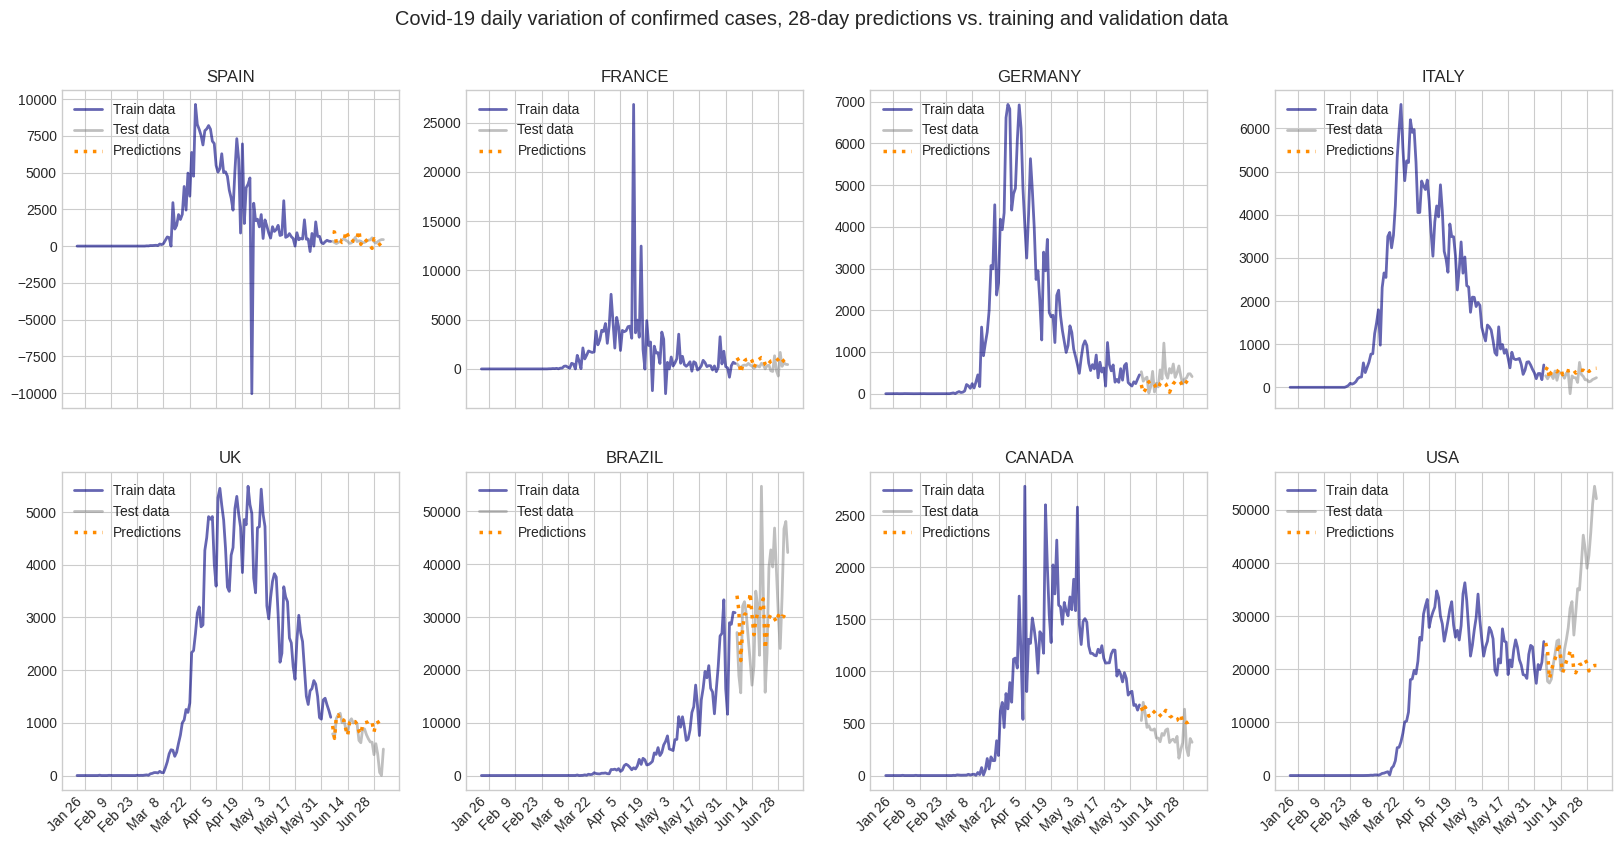

In [56]:
# Plotting actual training and test data vs. predictions: confirmed cases growth rate
fig1, ax1 = plt.subplots(2,4, figsize=(20,10))
fig1.subplots_adjust(top=0.90)
i = 0
j = 0
for x in df_cases_diff.columns:
  ax1[i,j].set_title(x)
  ax1[i,j].xaxis.set_major_formatter(my_date_fmt)
  ax1[i,j].xaxis.set_major_locator(plt.MultipleLocator(14))
  ax1[i,j].plot(df_cases_diff_train.index, df_cases_diff_train[x], lw=2, color='navy', alpha=0.6, label='Train data')
  ax1[i,j].plot(df_cases_diff_test.index, df_cases_diff_test[x], lw=2, color='grey', alpha=0.5, label='Test data')
  ax1[i,j].plot(df_cases_diff_test.index, df_cases_diff_test[x + '_PREDICTED'], lw=2.5, linestyle=':', color='darkorange', label='Predictions')
  ax1[i,j].legend(loc='upper left', fontsize='medium')
  if j < 3:
    j = j + 1
  else:
    j = 0
    i = i + 1

fig1.suptitle('Covid-19 daily variation of confirmed cases, ' + str(NBR_PREDICTIONS) + '-day predictions vs. training and validation data', fontsize='x-large')  
fig1.autofmt_xdate(rotation=45, ha='right')
plt.show()

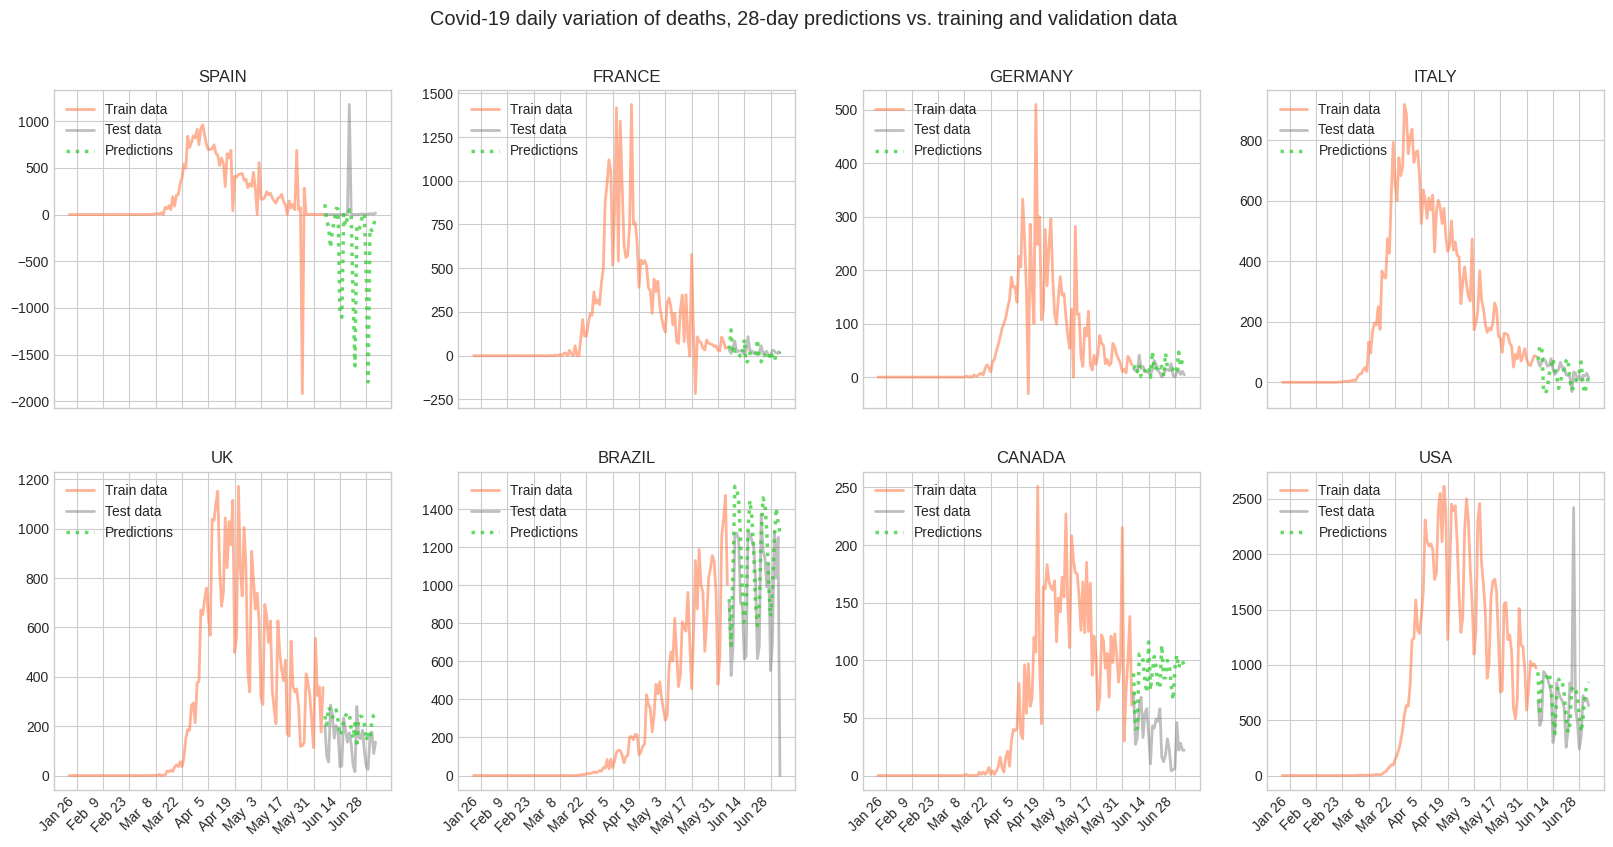

In [57]:
# Plotting actual training and test data vs. predictions: deaths growth rate
fig2, ax2 = plt.subplots(2,4, figsize=(20,10))
fig2.subplots_adjust(top=0.90)
i = 0
j = 0
for x in df_deaths_diff.columns:
  ax2[i,j].set_title(x)
  ax2[i,j].xaxis.set_major_formatter(my_date_fmt)
  ax2[i,j].xaxis.set_major_locator(plt.MultipleLocator(14))
  ax2[i,j].plot(df_deaths_diff_train.index, df_deaths_diff_train[x], linewidth=2, color='coral', alpha=0.6, label='Train data')
  ax2[i,j].plot(df_deaths_diff_test.index, df_deaths_diff_test[x], linewidth=2, color='grey', alpha=0.5, label='Test data')
  ax2[i,j].plot(df_deaths_diff_test.index, df_deaths_diff_test[x + '_PREDICTED'], linewidth=2.5, linestyle=':', alpha=0.75, color='limegreen', label='Predictions')
  ax2[i,j].legend(loc='upper left', fontsize='medium')
  if j < 3:
    j = j + 1
  else:
    j = 0
    i = i + 1

fig2.suptitle('Covid-19 daily variation of deaths, ' + str(NBR_PREDICTIONS) + '-day predictions vs. training and validation data', fontsize='x-large')  
fig2.autofmt_xdate(rotation=45, ha='right')
plt.show()

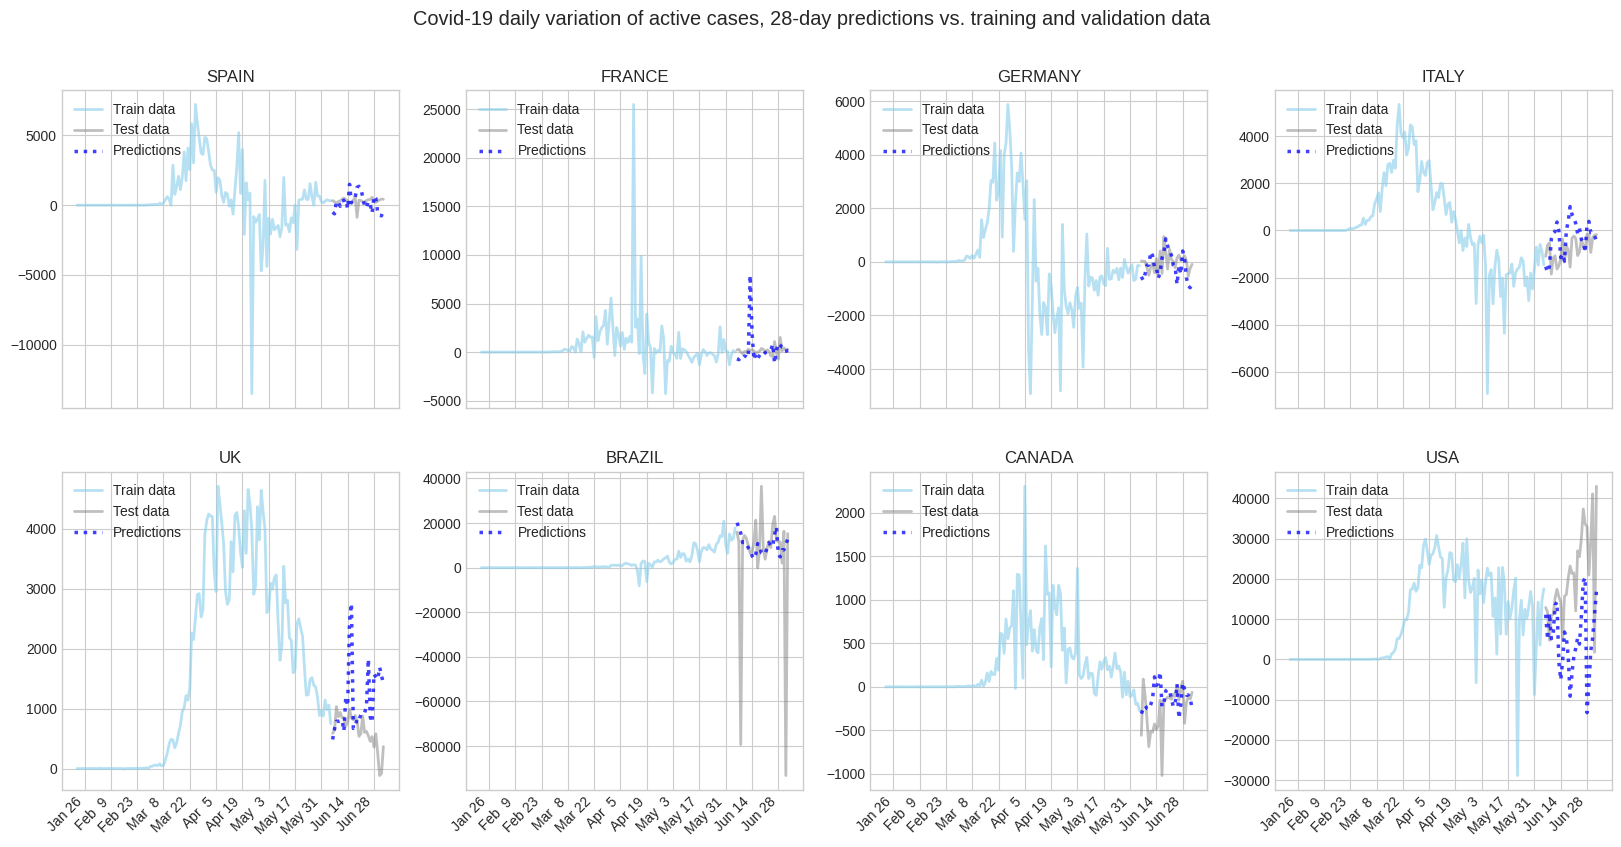

In [58]:
# Plotting actual training and test data vs. predictions: active cases growth rate
fig3, ax3 = plt.subplots(2,4, figsize=(20,10))
fig3.subplots_adjust(top=0.90)
i = 0
j = 0
for x in df_deaths_diff.columns:
  ax3[i,j].set_title(x)
  ax3[i,j].xaxis.set_major_formatter(my_date_fmt)
  ax3[i,j].xaxis.set_major_locator(plt.MultipleLocator(14))
  ax3[i,j].plot(df_active_diff_train.index, df_active_diff_train[x], linewidth=2, color='skyblue', alpha=0.6, label='Train data')
  ax3[i,j].plot(df_active_diff_test.index, df_active_diff_test[x], linewidth=2, color='grey', alpha=0.5, label='Test data')
  ax3[i,j].plot(df_active_diff_test.index, df_active_diff_test[x + '_PREDICTED'], linewidth=2.5, linestyle=':', color='blue', alpha=0.75, label='Predictions')
  ax3[i,j].legend(loc='upper left', fontsize='medium')
  if j < 3:
    j = j + 1
  else:
    j = 0
    i = i + 1

fig3.suptitle('Covid-19 daily variation of active cases, ' + str(NBR_PREDICTIONS) + '-day predictions vs. training and validation data', fontsize='x-large')  
fig3.autofmt_xdate(rotation=45, ha='right')
plt.show()